In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import optuna
from sklearn.metrics import jaccard_score

In [3]:
"""Reads a Surfer 6 GRD (Golden Software Grid) file and extracts its data.
    
    Parses the ASCII grid file format used by Golden Software Surfer (version 6)

    Args:
        file_path (str): Path to the .grd file to be read.

    Returns:
        list: A list containing the following elements in order:
            - Nx (int): Number of grid columns
            - Ny (int): Number of grid rows
            - xMin (float): Minimum X coordinate
            - xMax (float): Maximum X coordinate
            - yMin (float): Minimum Y coordinate
            - yMax (float): Maximum Y coordinate
            - zMin (float): Minimum Z value in grid
            - zMax (float): Maximum Z value in grid
            - grid_data (numpy.ndarray): 2D array of grid values with shape (Ny, Nx)
    """
def read_surfer6_grd(file_path):
    with open(file_path, 'r') as f:
        # Format check
        header = f.readline().strip()
        if header != "DSAA":
            raise ValueError("Wrong file format Surfer GRD ('DSAA')")

        # Reading grid sizes
        Nx, Ny = map(int, f.readline().split())
        
        # Reading X, Y, Z ranges
        xMin, xMax = map(float, f.readline().split())
        yMin, yMax = map(float, f.readline().split())
        zMin, zMax = map(float, f.readline().split())

        # Reading grid data
        grid_data = np.loadtxt(f)
        
        # Dimension check
        if grid_data.shape != (Ny, Nx):
            raise ValueError(
                f"Correct size {Ny}x{Nx}, but {grid_data.shape}"
            )

    return [Nx, Ny, xMin, xMax, yMin, yMax, zMin, zMax, grid_data]

"""Writes data to an ASCII grid file in Surfer 6 GRD format.

    Creates a Golden Software Surfer 6 compatible grid file (.grd)

    Args:
        Nx (int): Number of grid columns (cells in x-direction)
        Ny (int): Number of grid rows (cells in y-direction)
        xMin (float): Minimum X coordinate of the grid (left boundary)
        xMax (float): Maximum X coordinate of the grid (right boundary)
        yMin (float): Minimum Y coordinate of the grid (bottom boundary)
        yMax (float): Maximum Y coordinate of the grid (top boundary)
        zMin (float): Minimum Z value in the data (for scaling/display purposes)
        zMax (float): Maximum Z value in the data (for scaling/display purposes)
        data (array-like): 2D array of grid values with shape (Ny, Nx)
        file (str or file-like): Output file path or file object to write to
    """

def write_ascii_grid(Nx, Ny, xMin, xMax, yMin, yMax, zMin, zMax, data, file):
    with open(file, "w") as f:
        f.write("DSAA" + '\n')
        f.write("%s %s" % (Nx, Ny) + '\n')
        f.write("%s %s" % (xMin, xMax) + '\n')
        f.write("%s %s" % (yMin, yMax) + '\n')
        f.write("%s %s" % (zMin, zMax) + '\n')
        for row in data:
            f.write(' '.join([str(t) for t in row]) + '\n')

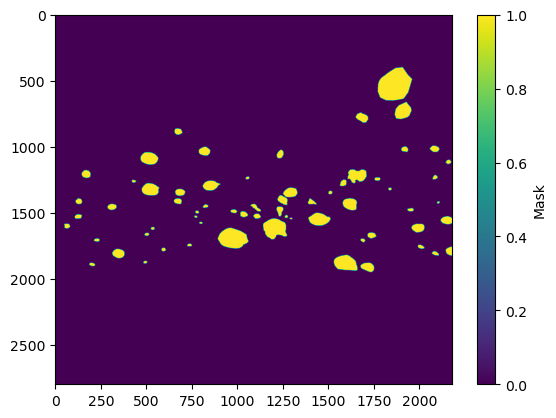

In [51]:
"""Uploading manual markup to validate results"""

file_manual_path = '../data/Manual_mask_dx5km.grd'  # Grid with manual markup (mask)
params = read_surfer6_grd(file_manual_path)

Nx, Ny, xMin, xMax, yMin, yMax, zMin, zMax, data_man = params
data_man[data_man == 1.70141e+38] = 0  # Manual mask array

plt.imshow(data_man, aspect='auto', cmap='viridis')
plt.colorbar(label='Mask') 
plt.show()

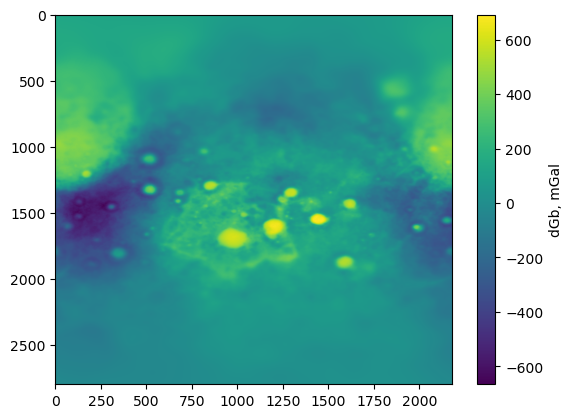

In [40]:
"""Uploading Gravity field. Use detailed grid with step 5 km"""

file_path = '../data/dGb255_Merc_dx5km.grd'  # Grid with gravity field
params = read_surfer6_grd(file_path)

Nx, Ny, xMin, xMax, yMin, yMax, zMin, zMax, data = params

plt.imshow(data, aspect='auto', cmap='viridis')
plt.colorbar(label='dGb, mGal') 
plt.show()

# Data normalization for OpenCV algorithm
data_norm = cv2.normalize(data, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

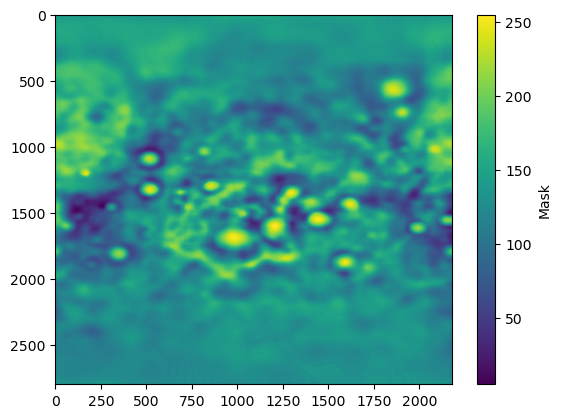

In [35]:
# Blur for gravity field
data_blur = cv2.blur(data_norm, (50, 50))

#CLAHE (Adaptive contrast enhancement)
clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(20, 20))
data_clahe = clahe.apply(data_blur)

plt.imshow(data_clahe, aspect='auto', cmap='viridis')
plt.colorbar(label='Mask') 
plt.show()

In [39]:
# 1. Adaptive thresholding

"""Optimizes binarization and morphological operation parameters to maximize the Jaccard score after adaptive tresholdeing

    This function is designed for hyperparameter tuning with Optuna. It evaluates a pipeline of 
    adaptive thresholding with morphological closing and erosion to maximize the Jaccard similarity coefficient (IoU) 
    between the predicted binary mask and the manualy created.

    Args:
        trial (optuna.Trial): An Optuna trial object that suggests hyperparameter values 
            for each optimization step. Used to sample parameters from predefined ranges.

    Returns:
        float: Jaccard score (Intersection over Union) between the predicted mask and ground truth. 
            The optimizer aims to maximize this value.
"""

def objective(trial):
    # boundaries for the optimizer's
    treshold = trial.suggest_int("treshold", 41, 101, step=2) # Threshold
    const = trial.suggest_int("const", 0, 5, step=1) # Constant adaptive_thresholding
    kernel_size_close = trial.suggest_int("kernel_size_close", 1, 31, step=2) # Kernel size for creating closed figure
    kernel_size_dil = trial.suggest_int("kernel_size_dil", 1, 31, step=2) # Kernel size for creating dilation
    
    # Сreate new model(and all parameters) every iteration
    adaptive_thresh = cv2.adaptiveThreshold(
        data_clahe, 1, 
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
        cv2.THRESH_BINARY, 
        treshold,  # Block size (must be odd)
        const    # Constant subtracted from the mean
    )
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size_close, kernel_size_close))
    closed = cv2.morphologyEx(adaptive_thresh, cv2.MORPH_CLOSE, kernel)
    kernel2 = np.ones((kernel_size_dil, kernel_size_dil), dtype=np.uint8)
    dilated = cv2.erode(closed, kernel2, iterations=1)
  
    pred = dilated # prediction
   
    error = jaccard_score(
        data_man.flatten(), 
        pred.flatten(), 
        average='binary'  # For Binary segmentation
    )
    print(error)
    return error


study = optuna.create_study(direction='maximize')  # Maximize IoU
study.optimize(objective, n_trials = 200)  # Number of iterations

[I 2025-06-05 15:19:48,812] A new study created in memory with name: no-name-c6cee101-d411-46a3-a4a5-9deacf2a653d
[I 2025-06-05 15:19:51,086] Trial 0 finished with value: 0.03428440589975901 and parameters: {'treshold': 85, 'const': 3, 'kernel_size_close': 27, 'kernel_size_dil': 1}. Best is trial 0 with value: 0.03428440589975901.


0.03428440589975901


[I 2025-06-05 15:19:53,165] Trial 1 finished with value: 0.03448982661807095 and parameters: {'treshold': 93, 'const': 4, 'kernel_size_close': 25, 'kernel_size_dil': 5}. Best is trial 1 with value: 0.03448982661807095.


0.03448982661807095


[I 2025-06-05 15:19:55,246] Trial 2 finished with value: 0.03387521724389708 and parameters: {'treshold': 85, 'const': 4, 'kernel_size_close': 29, 'kernel_size_dil': 13}. Best is trial 1 with value: 0.03448982661807095.


0.03387521724389708


[I 2025-06-05 15:19:57,321] Trial 3 finished with value: 0.03376109018007897 and parameters: {'treshold': 91, 'const': 5, 'kernel_size_close': 27, 'kernel_size_dil': 1}. Best is trial 1 with value: 0.03448982661807095.


0.03376109018007897


[I 2025-06-05 15:19:59,258] Trial 4 finished with value: 0.0341615936971237 and parameters: {'treshold': 65, 'const': 3, 'kernel_size_close': 11, 'kernel_size_dil': 9}. Best is trial 1 with value: 0.03448982661807095.


0.0341615936971237


[I 2025-06-05 15:20:01,274] Trial 5 finished with value: 0.03289997100146852 and parameters: {'treshold': 43, 'const': 1, 'kernel_size_close': 29, 'kernel_size_dil': 13}. Best is trial 1 with value: 0.03448982661807095.


0.03289997100146852


[I 2025-06-05 15:20:03,274] Trial 6 finished with value: 0.03422740768388557 and parameters: {'treshold': 73, 'const': 3, 'kernel_size_close': 21, 'kernel_size_dil': 7}. Best is trial 1 with value: 0.03448982661807095.


0.03422740768388557


[I 2025-06-05 15:20:05,410] Trial 7 finished with value: 0.031545694154612 and parameters: {'treshold': 75, 'const': 2, 'kernel_size_close': 25, 'kernel_size_dil': 29}. Best is trial 1 with value: 0.03448982661807095.


0.031545694154612


[I 2025-06-05 15:20:07,397] Trial 8 finished with value: 0.0346209479494336 and parameters: {'treshold': 67, 'const': 1, 'kernel_size_close': 17, 'kernel_size_dil': 25}. Best is trial 8 with value: 0.0346209479494336.


0.0346209479494336


[I 2025-06-05 15:20:09,413] Trial 9 finished with value: 0.03219257956631345 and parameters: {'treshold': 53, 'const': 1, 'kernel_size_close': 25, 'kernel_size_dil': 25}. Best is trial 8 with value: 0.0346209479494336.


0.03219257956631345


[I 2025-06-05 15:20:11,406] Trial 10 finished with value: 0.3035019105416948 and parameters: {'treshold': 59, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 21}. Best is trial 10 with value: 0.3035019105416948.


0.3035019105416948


[I 2025-06-05 15:20:13,380] Trial 11 finished with value: 0.3035019105416948 and parameters: {'treshold': 59, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 21}. Best is trial 10 with value: 0.3035019105416948.


0.3035019105416948


[I 2025-06-05 15:20:15,339] Trial 12 finished with value: 0.30962317118060023 and parameters: {'treshold': 57, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 19}. Best is trial 12 with value: 0.30962317118060023.


0.30962317118060023


[I 2025-06-05 15:20:17,275] Trial 13 finished with value: 0.26316918018726326 and parameters: {'treshold': 49, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 19}. Best is trial 12 with value: 0.30962317118060023.


0.26316918018726326


[I 2025-06-05 15:20:19,231] Trial 14 finished with value: 0.09932751659733216 and parameters: {'treshold': 57, 'const': 0, 'kernel_size_close': 7, 'kernel_size_dil': 17}. Best is trial 12 with value: 0.30962317118060023.


0.09932751659733216


[I 2025-06-05 15:20:21,213] Trial 15 finished with value: 0.03630704039822349 and parameters: {'treshold': 47, 'const': 2, 'kernel_size_close': 7, 'kernel_size_dil': 23}. Best is trial 12 with value: 0.30962317118060023.


0.03630704039822349


[I 2025-06-05 15:20:23,198] Trial 16 finished with value: 0.09571548010985181 and parameters: {'treshold': 61, 'const': 1, 'kernel_size_close': 5, 'kernel_size_dil': 29}. Best is trial 12 with value: 0.30962317118060023.


0.09571548010985181


[I 2025-06-05 15:20:25,148] Trial 17 finished with value: 0.05223549611762819 and parameters: {'treshold': 41, 'const': 0, 'kernel_size_close': 13, 'kernel_size_dil': 15}. Best is trial 12 with value: 0.30962317118060023.


0.05223549611762819


[I 2025-06-05 15:20:27,139] Trial 18 finished with value: 0.06343882618830014 and parameters: {'treshold': 77, 'const': 2, 'kernel_size_close': 5, 'kernel_size_dil': 31}. Best is trial 12 with value: 0.30962317118060023.


0.06343882618830014


[I 2025-06-05 15:20:29,150] Trial 19 finished with value: 0.06226416519958594 and parameters: {'treshold': 53, 'const': 0, 'kernel_size_close': 11, 'kernel_size_dil': 19}. Best is trial 12 with value: 0.30962317118060023.


0.06226416519958594


[I 2025-06-05 15:20:31,170] Trial 20 finished with value: 0.12456924261303662 and parameters: {'treshold': 99, 'const': 1, 'kernel_size_close': 1, 'kernel_size_dil': 11}. Best is trial 12 with value: 0.30962317118060023.


0.12456924261303662


[I 2025-06-05 15:20:33,115] Trial 21 finished with value: 0.3035019105416948 and parameters: {'treshold': 59, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 21}. Best is trial 12 with value: 0.30962317118060023.


0.3035019105416948


[I 2025-06-05 15:20:35,114] Trial 22 finished with value: 0.16025146881750357 and parameters: {'treshold': 67, 'const': 0, 'kernel_size_close': 5, 'kernel_size_dil': 23}. Best is trial 12 with value: 0.30962317118060023.


0.16025146881750357


[I 2025-06-05 15:20:37,164] Trial 23 finished with value: 0.1364762930082008 and parameters: {'treshold': 55, 'const': 1, 'kernel_size_close': 3, 'kernel_size_dil': 17}. Best is trial 12 with value: 0.30962317118060023.


0.1364762930082008


[I 2025-06-05 15:20:39,187] Trial 24 finished with value: 0.07961151190134455 and parameters: {'treshold': 61, 'const': 0, 'kernel_size_close': 9, 'kernel_size_dil': 21}. Best is trial 12 with value: 0.30962317118060023.


0.07961151190134455


[I 2025-06-05 15:20:41,164] Trial 25 finished with value: 0.176420502361316 and parameters: {'treshold': 49, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 27}. Best is trial 12 with value: 0.30962317118060023.


0.176420502361316


[I 2025-06-05 15:20:43,178] Trial 26 finished with value: 0.037075145399173726 and parameters: {'treshold': 65, 'const': 1, 'kernel_size_close': 15, 'kernel_size_dil': 19}. Best is trial 12 with value: 0.30962317118060023.


0.037075145399173726


[I 2025-06-05 15:20:45,172] Trial 27 finished with value: 0.07697270585816404 and parameters: {'treshold': 61, 'const': 2, 'kernel_size_close': 3, 'kernel_size_dil': 15}. Best is trial 12 with value: 0.30962317118060023.


0.07697270585816404


[I 2025-06-05 15:20:47,194] Trial 28 finished with value: 0.04619792752120141 and parameters: {'treshold': 71, 'const': 0, 'kernel_size_close': 19, 'kernel_size_dil': 23}. Best is trial 12 with value: 0.30962317118060023.


0.04619792752120141


[I 2025-06-05 15:20:49,186] Trial 29 finished with value: 0.07026575373424267 and parameters: {'treshold': 79, 'const': 1, 'kernel_size_close': 7, 'kernel_size_dil': 21}. Best is trial 12 with value: 0.30962317118060023.


0.07026575373424267


[I 2025-06-05 15:20:51,086] Trial 30 finished with value: 0.032661875599879334 and parameters: {'treshold': 51, 'const': 5, 'kernel_size_close': 3, 'kernel_size_dil': 25}. Best is trial 12 with value: 0.30962317118060023.


0.032661875599879334


[I 2025-06-05 15:20:53,092] Trial 31 finished with value: 0.28915297092288245 and parameters: {'treshold': 57, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 21}. Best is trial 12 with value: 0.30962317118060023.


0.28915297092288245


[I 2025-06-05 15:20:55,036] Trial 32 finished with value: 0.28684206903830006 and parameters: {'treshold': 59, 'const': 0, 'kernel_size_close': 3, 'kernel_size_dil': 19}. Best is trial 12 with value: 0.30962317118060023.


0.28684206903830006


[I 2025-06-05 15:20:56,981] Trial 33 finished with value: 0.13611179158556247 and parameters: {'treshold': 45, 'const': 0, 'kernel_size_close': 5, 'kernel_size_dil': 17}. Best is trial 12 with value: 0.30962317118060023.


0.13611179158556247


[I 2025-06-05 15:20:58,943] Trial 34 finished with value: 0.04235971825287515 and parameters: {'treshold': 69, 'const': 4, 'kernel_size_close': 1, 'kernel_size_dil': 21}. Best is trial 12 with value: 0.30962317118060023.


0.04235971825287515


[I 2025-06-05 15:21:00,947] Trial 35 finished with value: 0.11445350879700879 and parameters: {'treshold': 63, 'const': 1, 'kernel_size_close': 3, 'kernel_size_dil': 13}. Best is trial 12 with value: 0.30962317118060023.


0.11445350879700879


[I 2025-06-05 15:21:02,965] Trial 36 finished with value: 0.0515449856165063 and parameters: {'treshold': 83, 'const': 0, 'kernel_size_close': 9, 'kernel_size_dil': 1}. Best is trial 12 with value: 0.30962317118060023.


0.0515449856165063


[I 2025-06-05 15:21:04,942] Trial 37 finished with value: 0.05041019601645025 and parameters: {'treshold': 55, 'const': 1, 'kernel_size_close': 9, 'kernel_size_dil': 27}. Best is trial 12 with value: 0.30962317118060023.


0.05041019601645025


[I 2025-06-05 15:21:06,911] Trial 38 finished with value: 0.3444985237746947 and parameters: {'treshold': 59, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 15}. Best is trial 38 with value: 0.3444985237746947.


0.3444985237746947


[I 2025-06-05 15:21:09,063] Trial 39 finished with value: 0.03350888669264357 and parameters: {'treshold': 71, 'const': 3, 'kernel_size_close': 31, 'kernel_size_dil': 11}. Best is trial 38 with value: 0.3444985237746947.


0.03350888669264357


[I 2025-06-05 15:21:11,020] Trial 40 finished with value: 0.034295400355825935 and parameters: {'treshold': 65, 'const': 4, 'kernel_size_close': 5, 'kernel_size_dil': 15}. Best is trial 38 with value: 0.3444985237746947.


0.034295400355825935


[I 2025-06-05 15:21:12,996] Trial 41 finished with value: 0.28144756921735337 and parameters: {'treshold': 59, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 23}. Best is trial 38 with value: 0.3444985237746947.


0.28144756921735337


[I 2025-06-05 15:21:14,942] Trial 42 finished with value: 0.3014129503129789 and parameters: {'treshold': 51, 'const': 0, 'kernel_size_close': 3, 'kernel_size_dil': 19}. Best is trial 38 with value: 0.3444985237746947.


0.3014129503129789


[I 2025-06-05 15:21:16,897] Trial 43 finished with value: 0.31782652217434826 and parameters: {'treshold': 55, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 17}. Best is trial 38 with value: 0.3444985237746947.


0.31782652217434826


[I 2025-06-05 15:21:18,862] Trial 44 finished with value: 0.05441239419096355 and parameters: {'treshold': 55, 'const': 1, 'kernel_size_close': 7, 'kernel_size_dil': 13}. Best is trial 38 with value: 0.3444985237746947.


0.05441239419096355


[I 2025-06-05 15:21:20,833] Trial 45 finished with value: 0.2631149753012543 and parameters: {'treshold': 63, 'const': 0, 'kernel_size_close': 3, 'kernel_size_dil': 17}. Best is trial 38 with value: 0.3444985237746947.


0.2631149753012543


[I 2025-06-05 15:21:22,831] Trial 46 finished with value: 0.034132033603480674 and parameters: {'treshold': 53, 'const': 1, 'kernel_size_close': 21, 'kernel_size_dil': 11}. Best is trial 38 with value: 0.3444985237746947.


0.034132033603480674


[I 2025-06-05 15:21:24,839] Trial 47 finished with value: 0.13194698079591466 and parameters: {'treshold': 47, 'const': 0, 'kernel_size_close': 5, 'kernel_size_dil': 15}. Best is trial 38 with value: 0.3444985237746947.


0.13194698079591466


[I 2025-06-05 15:21:26,831] Trial 48 finished with value: 0.08846230914572227 and parameters: {'treshold': 51, 'const': 2, 'kernel_size_close': 1, 'kernel_size_dil': 9}. Best is trial 38 with value: 0.3444985237746947.


0.08846230914572227


[I 2025-06-05 15:21:28,800] Trial 49 finished with value: 0.04187043529855979 and parameters: {'treshold': 57, 'const': 1, 'kernel_size_close': 7, 'kernel_size_dil': 3}. Best is trial 38 with value: 0.3444985237746947.


0.04187043529855979


[I 2025-06-05 15:21:30,793] Trial 50 finished with value: 0.040168272290988474 and parameters: {'treshold': 43, 'const': 0, 'kernel_size_close': 23, 'kernel_size_dil': 17}. Best is trial 38 with value: 0.3444985237746947.


0.040168272290988474


[I 2025-06-05 15:21:32,786] Trial 51 finished with value: 0.3035019105416948 and parameters: {'treshold': 59, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 21}. Best is trial 38 with value: 0.3444985237746947.


0.3035019105416948


[I 2025-06-05 15:21:34,763] Trial 52 finished with value: 0.34908281475945213 and parameters: {'treshold': 63, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 19}. Best is trial 52 with value: 0.34908281475945213.


0.34908281475945213


[I 2025-06-05 15:21:36,757] Trial 53 finished with value: 0.2670643350199582 and parameters: {'treshold': 67, 'const': 0, 'kernel_size_close': 3, 'kernel_size_dil': 19}. Best is trial 52 with value: 0.34908281475945213.


0.2670643350199582


[I 2025-06-05 15:21:38,674] Trial 54 finished with value: 0.14211581225503686 and parameters: {'treshold': 63, 'const': 0, 'kernel_size_close': 5, 'kernel_size_dil': 17}. Best is trial 52 with value: 0.34908281475945213.


0.14211581225503686


[I 2025-06-05 15:21:40,685] Trial 55 finished with value: 0.24071429601742467 and parameters: {'treshold': 57, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 25}. Best is trial 52 with value: 0.34908281475945213.


0.24071429601742467


[I 2025-06-05 15:21:42,700] Trial 56 finished with value: 0.1249242978131874 and parameters: {'treshold': 61, 'const': 1, 'kernel_size_close': 3, 'kernel_size_dil': 15}. Best is trial 52 with value: 0.34908281475945213.


0.1249242978131874


[I 2025-06-05 15:21:44,708] Trial 57 finished with value: 0.28943495785650325 and parameters: {'treshold': 93, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 19}. Best is trial 52 with value: 0.34908281475945213.


0.28943495785650325


[I 2025-06-05 15:21:46,702] Trial 58 finished with value: 0.0914654706276875 and parameters: {'treshold': 69, 'const': 1, 'kernel_size_close': 5, 'kernel_size_dil': 23}. Best is trial 52 with value: 0.34908281475945213.


0.0914654706276875


[I 2025-06-05 15:21:48,686] Trial 59 finished with value: 0.05137034309876994 and parameters: {'treshold': 65, 'const': 0, 'kernel_size_close': 15, 'kernel_size_dil': 13}. Best is trial 52 with value: 0.34908281475945213.


0.05137034309876994


[I 2025-06-05 15:21:50,650] Trial 60 finished with value: 0.03300573418240362 and parameters: {'treshold': 53, 'const': 4, 'kernel_size_close': 11, 'kernel_size_dil': 19}. Best is trial 52 with value: 0.34908281475945213.


0.03300573418240362


[I 2025-06-05 15:21:52,614] Trial 61 finished with value: 0.3035019105416948 and parameters: {'treshold': 59, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 21}. Best is trial 52 with value: 0.34908281475945213.


0.3035019105416948


[I 2025-06-05 15:21:54,555] Trial 62 finished with value: 0.29853283044563017 and parameters: {'treshold': 55, 'const': 0, 'kernel_size_close': 3, 'kernel_size_dil': 21}. Best is trial 52 with value: 0.34908281475945213.


0.29853283044563017


[I 2025-06-05 15:21:56,575] Trial 63 finished with value: 0.3181566762719576 and parameters: {'treshold': 63, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 23}. Best is trial 52 with value: 0.34908281475945213.


0.3181566762719576


[I 2025-06-05 15:21:58,572] Trial 64 finished with value: 0.3429681797859291 and parameters: {'treshold': 75, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 23}. Best is trial 52 with value: 0.34908281475945213.


0.3429681797859291


[I 2025-06-05 15:22:00,576] Trial 65 finished with value: 0.2671321090487851 and parameters: {'treshold': 77, 'const': 0, 'kernel_size_close': 3, 'kernel_size_dil': 25}. Best is trial 52 with value: 0.34908281475945213.


0.2671321090487851


[I 2025-06-05 15:22:02,566] Trial 66 finished with value: 0.31668909589807226 and parameters: {'treshold': 73, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 27}. Best is trial 52 with value: 0.34908281475945213.


0.31668909589807226


[I 2025-06-05 15:22:04,596] Trial 67 finished with value: 0.31668909589807226 and parameters: {'treshold': 73, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 27}. Best is trial 52 with value: 0.34908281475945213.


0.31668909589807226


[I 2025-06-05 15:22:06,688] Trial 68 finished with value: 0.03748046968129403 and parameters: {'treshold': 75, 'const': 0, 'kernel_size_close': 27, 'kernel_size_dil': 29}. Best is trial 52 with value: 0.34908281475945213.


0.03748046968129403


[I 2025-06-05 15:22:08,729] Trial 69 finished with value: 0.09913401115872092 and parameters: {'treshold': 75, 'const': 1, 'kernel_size_close': 5, 'kernel_size_dil': 27}. Best is trial 52 with value: 0.34908281475945213.


0.09913401115872092


[I 2025-06-05 15:22:10,776] Trial 70 finished with value: 0.2668598884619268 and parameters: {'treshold': 81, 'const': 0, 'kernel_size_close': 3, 'kernel_size_dil': 31}. Best is trial 52 with value: 0.34908281475945213.


0.2668598884619268


[I 2025-06-05 15:22:12,829] Trial 71 finished with value: 0.29812335357034364 and parameters: {'treshold': 73, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 29}. Best is trial 52 with value: 0.34908281475945213.


0.29812335357034364


[I 2025-06-05 15:22:14,820] Trial 72 finished with value: 0.31668909589807226 and parameters: {'treshold': 73, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 27}. Best is trial 52 with value: 0.34908281475945213.


0.31668909589807226


[I 2025-06-05 15:22:16,856] Trial 73 finished with value: 0.31668909589807226 and parameters: {'treshold': 73, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 27}. Best is trial 52 with value: 0.34908281475945213.


0.31668909589807226


[I 2025-06-05 15:22:18,866] Trial 74 finished with value: 0.288093194423664 and parameters: {'treshold': 69, 'const': 0, 'kernel_size_close': 3, 'kernel_size_dil': 25}. Best is trial 52 with value: 0.34908281475945213.


0.288093194423664


[I 2025-06-05 15:22:20,912] Trial 75 finished with value: 0.23949860485515448 and parameters: {'treshold': 79, 'const': 1, 'kernel_size_close': 1, 'kernel_size_dil': 27}. Best is trial 52 with value: 0.34908281475945213.


0.23949860485515448


[I 2025-06-05 15:22:22,929] Trial 76 finished with value: 0.28696567596835154 and parameters: {'treshold': 71, 'const': 0, 'kernel_size_close': 3, 'kernel_size_dil': 29}. Best is trial 52 with value: 0.34908281475945213.


0.28696567596835154


[I 2025-06-05 15:22:24,976] Trial 77 finished with value: 0.3018538986090547 and parameters: {'treshold': 87, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 31}. Best is trial 52 with value: 0.34908281475945213.


0.3018538986090547


[I 2025-06-05 15:22:26,994] Trial 78 finished with value: 0.1591582221609469 and parameters: {'treshold': 77, 'const': 0, 'kernel_size_close': 5, 'kernel_size_dil': 23}. Best is trial 52 with value: 0.34908281475945213.


0.1591582221609469


[I 2025-06-05 15:22:29,088] Trial 79 finished with value: 0.2409484342415519 and parameters: {'treshold': 73, 'const': 1, 'kernel_size_close': 1, 'kernel_size_dil': 25}. Best is trial 52 with value: 0.34908281475945213.


0.2409484342415519


[I 2025-06-05 15:22:31,093] Trial 80 finished with value: 0.2931829076109943 and parameters: {'treshold': 67, 'const': 0, 'kernel_size_close': 3, 'kernel_size_dil': 29}. Best is trial 52 with value: 0.34908281475945213.


0.2931829076109943


[I 2025-06-05 15:22:33,098] Trial 81 finished with value: 0.31668909589807226 and parameters: {'treshold': 73, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 27}. Best is trial 52 with value: 0.34908281475945213.


0.31668909589807226


[I 2025-06-05 15:22:35,099] Trial 82 finished with value: 0.3255370981982277 and parameters: {'treshold': 79, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 27}. Best is trial 52 with value: 0.34908281475945213.


0.3255370981982277


[I 2025-06-05 15:22:37,128] Trial 83 finished with value: 0.31441082276809296 and parameters: {'treshold': 83, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 29}. Best is trial 52 with value: 0.34908281475945213.


0.31441082276809296


[I 2025-06-05 15:22:39,145] Trial 84 finished with value: 0.2556705274056734 and parameters: {'treshold': 79, 'const': 0, 'kernel_size_close': 3, 'kernel_size_dil': 23}. Best is trial 52 with value: 0.34908281475945213.


0.2556705274056734


[I 2025-06-05 15:22:41,171] Trial 85 finished with value: 0.3219076643866693 and parameters: {'treshold': 75, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 27}. Best is trial 52 with value: 0.34908281475945213.


0.3219076643866693


[I 2025-06-05 15:22:43,195] Trial 86 finished with value: 0.2671321090487851 and parameters: {'treshold': 77, 'const': 0, 'kernel_size_close': 3, 'kernel_size_dil': 25}. Best is trial 52 with value: 0.34908281475945213.


0.2671321090487851


[I 2025-06-05 15:22:45,278] Trial 87 finished with value: 0.12795771496663724 and parameters: {'treshold': 87, 'const': 0, 'kernel_size_close': 7, 'kernel_size_dil': 31}. Best is trial 52 with value: 0.34908281475945213.


0.12795771496663724


[I 2025-06-05 15:22:47,312] Trial 88 finished with value: 0.0352248574350114 and parameters: {'treshold': 75, 'const': 5, 'kernel_size_close': 1, 'kernel_size_dil': 27}. Best is trial 52 with value: 0.34908281475945213.


0.0352248574350114


[I 2025-06-05 15:22:49,356] Trial 89 finished with value: 0.09539887476447016 and parameters: {'treshold': 83, 'const': 1, 'kernel_size_close': 5, 'kernel_size_dil': 23}. Best is trial 52 with value: 0.34908281475945213.


0.09539887476447016


[I 2025-06-05 15:22:51,395] Trial 90 finished with value: 0.2582447549068114 and parameters: {'treshold': 81, 'const': 0, 'kernel_size_close': 3, 'kernel_size_dil': 25}. Best is trial 52 with value: 0.34908281475945213.


0.2582447549068114


[I 2025-06-05 15:22:53,428] Trial 91 finished with value: 0.3133595197377797 and parameters: {'treshold': 71, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 27}. Best is trial 52 with value: 0.34908281475945213.


0.3133595197377797


[I 2025-06-05 15:22:55,495] Trial 92 finished with value: 0.33492749270306277 and parameters: {'treshold': 79, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 25}. Best is trial 52 with value: 0.34908281475945213.


0.33492749270306277


[I 2025-06-05 15:22:57,552] Trial 93 finished with value: 0.3313423345925122 and parameters: {'treshold': 81, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 25}. Best is trial 52 with value: 0.34908281475945213.


0.3313423345925122


[I 2025-06-05 15:22:59,590] Trial 94 finished with value: 0.2582447549068114 and parameters: {'treshold': 81, 'const': 0, 'kernel_size_close': 3, 'kernel_size_dil': 25}. Best is trial 52 with value: 0.34908281475945213.


0.2582447549068114


[I 2025-06-05 15:23:01,672] Trial 95 finished with value: 0.33951409176988895 and parameters: {'treshold': 79, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 23}. Best is trial 52 with value: 0.34908281475945213.


0.33951409176988895


[I 2025-06-05 15:23:03,729] Trial 96 finished with value: 0.08690196574810345 and parameters: {'treshold': 79, 'const': 3, 'kernel_size_close': 1, 'kernel_size_dil': 23}. Best is trial 52 with value: 0.34908281475945213.


0.08690196574810345


[I 2025-06-05 15:23:05,711] Trial 97 finished with value: 0.24443558005350868 and parameters: {'treshold': 85, 'const': 0, 'kernel_size_close': 3, 'kernel_size_dil': 23}. Best is trial 52 with value: 0.34908281475945213.


0.24443558005350868


[I 2025-06-05 15:23:07,788] Trial 98 finished with value: 0.17416574310670976 and parameters: {'treshold': 101, 'const': 0, 'kernel_size_close': 3, 'kernel_size_dil': 15}. Best is trial 52 with value: 0.34908281475945213.


0.17416574310670976


[I 2025-06-05 15:23:09,898] Trial 99 finished with value: 0.05197367320909261 and parameters: {'treshold': 81, 'const': 0, 'kernel_size_close': 17, 'kernel_size_dil': 25}. Best is trial 52 with value: 0.34908281475945213.


0.05197367320909261


[I 2025-06-05 15:23:11,944] Trial 100 finished with value: 0.2944403543353837 and parameters: {'treshold': 87, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 17}. Best is trial 52 with value: 0.34908281475945213.


0.2944403543353837


[I 2025-06-05 15:23:14,006] Trial 101 finished with value: 0.3342761635381846 and parameters: {'treshold': 77, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 25}. Best is trial 52 with value: 0.34908281475945213.


0.3342761635381846


[I 2025-06-05 15:23:16,025] Trial 102 finished with value: 0.34173723354918495 and parameters: {'treshold': 77, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 21}. Best is trial 52 with value: 0.34908281475945213.


0.34173723354918495


[I 2025-06-05 15:23:18,128] Trial 103 finished with value: 0.34173723354918495 and parameters: {'treshold': 77, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 21}. Best is trial 52 with value: 0.34908281475945213.


0.34173723354918495


[I 2025-06-05 15:23:20,158] Trial 104 finished with value: 0.25143215305482874 and parameters: {'treshold': 77, 'const': 0, 'kernel_size_close': 3, 'kernel_size_dil': 21}. Best is trial 52 with value: 0.34908281475945213.


0.25143215305482874


[I 2025-06-05 15:23:22,181] Trial 105 finished with value: 0.15198942109257532 and parameters: {'treshold': 79, 'const': 0, 'kernel_size_close': 5, 'kernel_size_dil': 21}. Best is trial 52 with value: 0.34908281475945213.


0.15198942109257532


[I 2025-06-05 15:23:24,203] Trial 106 finished with value: 0.33095357092044636 and parameters: {'treshold': 83, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 25}. Best is trial 52 with value: 0.34908281475945213.


0.33095357092044636


[I 2025-06-05 15:23:26,244] Trial 107 finished with value: 0.24750889313840396 and parameters: {'treshold': 83, 'const': 0, 'kernel_size_close': 3, 'kernel_size_dil': 23}. Best is trial 52 with value: 0.34908281475945213.


0.24750889313840396


[I 2025-06-05 15:23:28,309] Trial 108 finished with value: 0.18859707833779538 and parameters: {'treshold': 89, 'const': 1, 'kernel_size_close': 1, 'kernel_size_dil': 19}. Best is trial 52 with value: 0.34908281475945213.


0.18859707833779538


[I 2025-06-05 15:23:30,326] Trial 109 finished with value: 0.3342761635381846 and parameters: {'treshold': 77, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 25}. Best is trial 52 with value: 0.34908281475945213.


0.3342761635381846


[I 2025-06-05 15:23:32,389] Trial 110 finished with value: 0.24213397699346506 and parameters: {'treshold': 81, 'const': 0, 'kernel_size_close': 3, 'kernel_size_dil': 21}. Best is trial 52 with value: 0.34908281475945213.


0.24213397699346506


[I 2025-06-05 15:23:34,431] Trial 111 finished with value: 0.3274535686658576 and parameters: {'treshold': 85, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 25}. Best is trial 52 with value: 0.34908281475945213.


0.3274535686658576


[I 2025-06-05 15:23:36,501] Trial 112 finished with value: 0.3274535686658576 and parameters: {'treshold': 85, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 25}. Best is trial 52 with value: 0.34908281475945213.


0.3274535686658576


[I 2025-06-05 15:23:38,556] Trial 113 finished with value: 0.3342761635381846 and parameters: {'treshold': 77, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 25}. Best is trial 52 with value: 0.34908281475945213.


0.3342761635381846


[I 2025-06-05 15:23:40,582] Trial 114 finished with value: 0.3406058226826116 and parameters: {'treshold': 77, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 23}. Best is trial 52 with value: 0.34908281475945213.


0.3406058226826116


[I 2025-06-05 15:23:42,637] Trial 115 finished with value: 0.06419921857376176 and parameters: {'treshold': 77, 'const': 0, 'kernel_size_close': 13, 'kernel_size_dil': 23}. Best is trial 52 with value: 0.34908281475945213.


0.06419921857376176


[I 2025-06-05 15:23:44,661] Trial 116 finished with value: 0.34601888954527016 and parameters: {'treshold': 75, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 21}. Best is trial 52 with value: 0.34908281475945213.


0.34601888954527016


[I 2025-06-05 15:23:46,692] Trial 117 finished with value: 0.26531684864533617 and parameters: {'treshold': 75, 'const': 0, 'kernel_size_close': 3, 'kernel_size_dil': 23}. Best is trial 52 with value: 0.34908281475945213.


0.26531684864533617


[I 2025-06-05 15:23:48,788] Trial 118 finished with value: 0.25143215305482874 and parameters: {'treshold': 77, 'const': 0, 'kernel_size_close': 3, 'kernel_size_dil': 21}. Best is trial 52 with value: 0.34908281475945213.


0.25143215305482874


[I 2025-06-05 15:23:50,910] Trial 119 finished with value: 0.03427583827898409 and parameters: {'treshold': 79, 'const': 2, 'kernel_size_close': 25, 'kernel_size_dil': 19}. Best is trial 52 with value: 0.34908281475945213.


0.03427583827898409


[I 2025-06-05 15:23:52,910] Trial 120 finished with value: 0.34601888954527016 and parameters: {'treshold': 75, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 21}. Best is trial 52 with value: 0.34908281475945213.


0.34601888954527016


[I 2025-06-05 15:23:54,921] Trial 121 finished with value: 0.34601888954527016 and parameters: {'treshold': 75, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 21}. Best is trial 52 with value: 0.34908281475945213.


0.34601888954527016


[I 2025-06-05 15:23:56,955] Trial 122 finished with value: 0.34601888954527016 and parameters: {'treshold': 75, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 21}. Best is trial 52 with value: 0.34908281475945213.


0.34601888954527016


[I 2025-06-05 15:23:58,977] Trial 123 finished with value: 0.34601888954527016 and parameters: {'treshold': 75, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 21}. Best is trial 52 with value: 0.34908281475945213.


0.34601888954527016


[I 2025-06-05 15:24:01,026] Trial 124 finished with value: 0.25685941879333235 and parameters: {'treshold': 71, 'const': 0, 'kernel_size_close': 3, 'kernel_size_dil': 19}. Best is trial 52 with value: 0.34908281475945213.


0.25685941879333235


[I 2025-06-05 15:24:03,041] Trial 125 finished with value: 0.34601888954527016 and parameters: {'treshold': 75, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 21}. Best is trial 52 with value: 0.34908281475945213.


0.34601888954527016


[I 2025-06-05 15:24:05,103] Trial 126 finished with value: 0.34601888954527016 and parameters: {'treshold': 75, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 21}. Best is trial 52 with value: 0.34908281475945213.


0.34601888954527016


[I 2025-06-05 15:24:07,119] Trial 127 finished with value: 0.25643116734152654 and parameters: {'treshold': 75, 'const': 0, 'kernel_size_close': 3, 'kernel_size_dil': 21}. Best is trial 52 with value: 0.34908281475945213.


0.25643116734152654


[I 2025-06-05 15:24:09,158] Trial 128 finished with value: 0.1539850179969983 and parameters: {'treshold': 69, 'const': 0, 'kernel_size_close': 5, 'kernel_size_dil': 21}. Best is trial 52 with value: 0.34908281475945213.


0.1539850179969983


[I 2025-06-05 15:24:11,193] Trial 129 finished with value: 0.34382631758619786 and parameters: {'treshold': 75, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 19}. Best is trial 52 with value: 0.34908281475945213.


0.34382631758619786


[I 2025-06-05 15:24:13,281] Trial 130 finished with value: 0.24582478379579187 and parameters: {'treshold': 75, 'const': 0, 'kernel_size_close': 3, 'kernel_size_dil': 19}. Best is trial 52 with value: 0.34908281475945213.


0.24582478379579187


[I 2025-06-05 15:24:15,286] Trial 131 finished with value: 0.35011856233181465 and parameters: {'treshold': 71, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 21}. Best is trial 131 with value: 0.35011856233181465.


0.35011856233181465


[I 2025-06-05 15:24:17,303] Trial 132 finished with value: 0.35011856233181465 and parameters: {'treshold': 71, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 21}. Best is trial 131 with value: 0.35011856233181465.


0.35011856233181465


[I 2025-06-05 15:24:19,327] Trial 133 finished with value: 0.3520098217855412 and parameters: {'treshold': 71, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 19}. Best is trial 133 with value: 0.3520098217855412.


0.3520098217855412


[I 2025-06-05 15:24:21,436] Trial 134 finished with value: 0.3520098217855412 and parameters: {'treshold': 71, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 19}. Best is trial 133 with value: 0.3520098217855412.


0.3520098217855412


[I 2025-06-05 15:24:23,459] Trial 135 finished with value: 0.3520098217855412 and parameters: {'treshold': 71, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 19}. Best is trial 133 with value: 0.3520098217855412.


0.3520098217855412


[I 2025-06-05 15:24:25,476] Trial 136 finished with value: 0.24442997291561713 and parameters: {'treshold': 71, 'const': 0, 'kernel_size_close': 3, 'kernel_size_dil': 17}. Best is trial 133 with value: 0.3520098217855412.


0.24442997291561713


[I 2025-06-05 15:24:27,474] Trial 137 finished with value: 0.3545551880669693 and parameters: {'treshold': 69, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 19}. Best is trial 137 with value: 0.3545551880669693.


0.3545551880669693


[I 2025-06-05 15:24:29,458] Trial 138 finished with value: 0.3545551880669693 and parameters: {'treshold': 69, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 19}. Best is trial 137 with value: 0.3545551880669693.


0.3545551880669693


[I 2025-06-05 15:24:31,440] Trial 139 finished with value: 0.14122247735717325 and parameters: {'treshold': 69, 'const': 1, 'kernel_size_close': 3, 'kernel_size_dil': 19}. Best is trial 137 with value: 0.3545551880669693.


0.14122247735717325


[I 2025-06-05 15:24:33,413] Trial 140 finished with value: 0.35506974949206027 and parameters: {'treshold': 67, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 19}. Best is trial 140 with value: 0.35506974949206027.


0.35506974949206027


[I 2025-06-05 15:24:35,392] Trial 141 finished with value: 0.3545551880669693 and parameters: {'treshold': 69, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 19}. Best is trial 140 with value: 0.35506974949206027.


0.3545551880669693


[I 2025-06-05 15:24:37,441] Trial 142 finished with value: 0.35506974949206027 and parameters: {'treshold': 67, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 19}. Best is trial 140 with value: 0.35506974949206027.


0.35506974949206027


[I 2025-06-05 15:24:39,411] Trial 143 finished with value: 0.35506974949206027 and parameters: {'treshold': 67, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 19}. Best is trial 140 with value: 0.35506974949206027.


0.35506974949206027


[I 2025-06-05 15:24:41,398] Trial 144 finished with value: 0.2670643350199582 and parameters: {'treshold': 67, 'const': 0, 'kernel_size_close': 3, 'kernel_size_dil': 19}. Best is trial 140 with value: 0.35506974949206027.


0.2670643350199582


[I 2025-06-05 15:24:43,380] Trial 145 finished with value: 0.35550251829493007 and parameters: {'treshold': 67, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 17}. Best is trial 145 with value: 0.35550251829493007.


0.35550251829493007


[I 2025-06-05 15:24:45,335] Trial 146 finished with value: 0.3591430086101311 and parameters: {'treshold': 65, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 17}. Best is trial 146 with value: 0.3591430086101311.


0.3591430086101311


[I 2025-06-05 15:24:47,331] Trial 147 finished with value: 0.259522859802078 and parameters: {'treshold': 65, 'const': 0, 'kernel_size_close': 3, 'kernel_size_dil': 17}. Best is trial 146 with value: 0.3591430086101311.


0.259522859802078


[I 2025-06-05 15:24:49,434] Trial 148 finished with value: 0.03891981341767682 and parameters: {'treshold': 67, 'const': 0, 'kernel_size_close': 31, 'kernel_size_dil': 17}. Best is trial 146 with value: 0.3591430086101311.


0.03891981341767682


[I 2025-06-05 15:24:51,408] Trial 149 finished with value: 0.35618426678906134 and parameters: {'treshold': 65, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 19}. Best is trial 146 with value: 0.3591430086101311.


0.35618426678906134


[I 2025-06-05 15:24:53,411] Trial 150 finished with value: 0.2718735704063089 and parameters: {'treshold': 65, 'const': 0, 'kernel_size_close': 3, 'kernel_size_dil': 19}. Best is trial 146 with value: 0.3591430086101311.


0.2718735704063089


[I 2025-06-05 15:24:55,406] Trial 151 finished with value: 0.3545551880669693 and parameters: {'treshold': 69, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 19}. Best is trial 146 with value: 0.3591430086101311.


0.3545551880669693


[I 2025-06-05 15:24:57,367] Trial 152 finished with value: 0.35550251829493007 and parameters: {'treshold': 67, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 17}. Best is trial 146 with value: 0.3591430086101311.


0.35550251829493007


[I 2025-06-05 15:24:59,337] Trial 153 finished with value: 0.3526379213464129 and parameters: {'treshold': 69, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 17}. Best is trial 146 with value: 0.3591430086101311.


0.3526379213464129


[I 2025-06-05 15:25:01,326] Trial 154 finished with value: 0.3526379213464129 and parameters: {'treshold': 69, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 17}. Best is trial 146 with value: 0.3591430086101311.


0.3526379213464129


[I 2025-06-05 15:25:03,316] Trial 155 finished with value: 0.35550251829493007 and parameters: {'treshold': 67, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 17}. Best is trial 146 with value: 0.3591430086101311.


0.35550251829493007


[I 2025-06-05 15:25:05,292] Trial 156 finished with value: 0.35550251829493007 and parameters: {'treshold': 67, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 17}. Best is trial 146 with value: 0.3591430086101311.


0.35550251829493007


[I 2025-06-05 15:25:07,274] Trial 157 finished with value: 0.3526379213464129 and parameters: {'treshold': 69, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 17}. Best is trial 146 with value: 0.3591430086101311.


0.3526379213464129


[I 2025-06-05 15:25:09,327] Trial 158 finished with value: 0.04612121878619149 and parameters: {'treshold': 67, 'const': 0, 'kernel_size_close': 19, 'kernel_size_dil': 15}. Best is trial 146 with value: 0.3591430086101311.


0.04612121878619149


[I 2025-06-05 15:25:11,434] Trial 159 finished with value: 0.2545900378051953 and parameters: {'treshold': 67, 'const': 0, 'kernel_size_close': 3, 'kernel_size_dil': 17}. Best is trial 146 with value: 0.3591430086101311.


0.2545900378051953


[I 2025-06-05 15:25:13,414] Trial 160 finished with value: 0.3526379213464129 and parameters: {'treshold': 69, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 17}. Best is trial 146 with value: 0.3591430086101311.


0.3526379213464129


[I 2025-06-05 15:25:15,402] Trial 161 finished with value: 0.3526379213464129 and parameters: {'treshold': 69, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 17}. Best is trial 146 with value: 0.3591430086101311.


0.3526379213464129


[I 2025-06-05 15:25:17,377] Trial 162 finished with value: 0.3591430086101311 and parameters: {'treshold': 65, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 17}. Best is trial 146 with value: 0.3591430086101311.


0.3591430086101311


[I 2025-06-05 15:25:19,335] Trial 163 finished with value: 0.35526558976823275 and parameters: {'treshold': 65, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 15}. Best is trial 146 with value: 0.3591430086101311.


0.35526558976823275


[I 2025-06-05 15:25:21,320] Trial 164 finished with value: 0.35526558976823275 and parameters: {'treshold': 65, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 15}. Best is trial 146 with value: 0.3591430086101311.


0.35526558976823275


[I 2025-06-05 15:25:23,304] Trial 165 finished with value: 0.07750367410776483 and parameters: {'treshold': 65, 'const': 2, 'kernel_size_close': 3, 'kernel_size_dil': 15}. Best is trial 146 with value: 0.3591430086101311.


0.07750367410776483


[I 2025-06-05 15:25:25,322] Trial 166 finished with value: 0.35562728354300277 and parameters: {'treshold': 63, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 15}. Best is trial 146 with value: 0.3591430086101311.


0.35562728354300277


[I 2025-06-05 15:25:27,292] Trial 167 finished with value: 0.35562728354300277 and parameters: {'treshold': 63, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 15}. Best is trial 146 with value: 0.3591430086101311.


0.35562728354300277


[I 2025-06-05 15:25:29,268] Trial 168 finished with value: 0.23923566505639218 and parameters: {'treshold': 61, 'const': 0, 'kernel_size_close': 3, 'kernel_size_dil': 13}. Best is trial 146 with value: 0.3591430086101311.


0.23923566505639218


[I 2025-06-05 15:25:31,357] Trial 169 finished with value: 0.03940536435489848 and parameters: {'treshold': 63, 'const': 0, 'kernel_size_close': 29, 'kernel_size_dil': 15}. Best is trial 146 with value: 0.3591430086101311.


0.03940536435489848


[I 2025-06-05 15:25:33,339] Trial 170 finished with value: 0.342819056275089 and parameters: {'treshold': 65, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 13}. Best is trial 146 with value: 0.3591430086101311.


0.342819056275089


[I 2025-06-05 15:25:35,325] Trial 171 finished with value: 0.35562728354300277 and parameters: {'treshold': 63, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 15}. Best is trial 146 with value: 0.3591430086101311.


0.35562728354300277


[I 2025-06-05 15:25:37,319] Trial 172 finished with value: 0.35562728354300277 and parameters: {'treshold': 63, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 15}. Best is trial 146 with value: 0.3591430086101311.


0.35562728354300277


[I 2025-06-05 15:25:39,284] Trial 173 finished with value: 0.3481218259188758 and parameters: {'treshold': 61, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 15}. Best is trial 146 with value: 0.3591430086101311.


0.3481218259188758


[I 2025-06-05 15:25:41,329] Trial 174 finished with value: 0.35562728354300277 and parameters: {'treshold': 63, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 15}. Best is trial 146 with value: 0.3591430086101311.


0.35562728354300277


[I 2025-06-05 15:25:43,314] Trial 175 finished with value: 0.24939849571009257 and parameters: {'treshold': 63, 'const': 0, 'kernel_size_close': 3, 'kernel_size_dil': 15}. Best is trial 146 with value: 0.3591430086101311.


0.24939849571009257


[I 2025-06-05 15:25:45,287] Trial 176 finished with value: 0.35562728354300277 and parameters: {'treshold': 63, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 15}. Best is trial 146 with value: 0.3591430086101311.


0.35562728354300277


[I 2025-06-05 15:25:47,260] Trial 177 finished with value: 0.036299765350859214 and parameters: {'treshold': 63, 'const': 5, 'kernel_size_close': 1, 'kernel_size_dil': 15}. Best is trial 146 with value: 0.3591430086101311.


0.036299765350859214


[I 2025-06-05 15:25:49,232] Trial 178 finished with value: 0.35526558976823275 and parameters: {'treshold': 65, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 15}. Best is trial 146 with value: 0.3591430086101311.


0.35526558976823275


[I 2025-06-05 15:25:51,240] Trial 179 finished with value: 0.2451939453382425 and parameters: {'treshold': 65, 'const': 0, 'kernel_size_close': 3, 'kernel_size_dil': 15}. Best is trial 146 with value: 0.3591430086101311.


0.2451939453382425


[I 2025-06-05 15:25:53,208] Trial 180 finished with value: 0.3460078469369217 and parameters: {'treshold': 63, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 13}. Best is trial 146 with value: 0.3591430086101311.


0.3460078469369217


[I 2025-06-05 15:25:55,179] Trial 181 finished with value: 0.35526558976823275 and parameters: {'treshold': 65, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 15}. Best is trial 146 with value: 0.3591430086101311.


0.35526558976823275


[I 2025-06-05 15:25:57,223] Trial 182 finished with value: 0.35526558976823275 and parameters: {'treshold': 65, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 15}. Best is trial 146 with value: 0.3591430086101311.


0.35526558976823275


[I 2025-06-05 15:25:59,183] Trial 183 finished with value: 0.07056931708713411 and parameters: {'treshold': 61, 'const': 3, 'kernel_size_close': 1, 'kernel_size_dil': 15}. Best is trial 146 with value: 0.3591430086101311.


0.07056931708713411


[I 2025-06-05 15:26:01,259] Trial 184 finished with value: 0.041750761621183796 and parameters: {'treshold': 65, 'const': 0, 'kernel_size_close': 23, 'kernel_size_dil': 13}. Best is trial 146 with value: 0.3591430086101311.


0.041750761621183796


[I 2025-06-05 15:26:03,240] Trial 185 finished with value: 0.35562728354300277 and parameters: {'treshold': 63, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 15}. Best is trial 146 with value: 0.3591430086101311.


0.35562728354300277


[I 2025-06-05 15:26:05,208] Trial 186 finished with value: 0.35562728354300277 and parameters: {'treshold': 63, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 15}. Best is trial 146 with value: 0.3591430086101311.


0.35562728354300277


[I 2025-06-05 15:26:07,191] Trial 187 finished with value: 0.24939849571009257 and parameters: {'treshold': 63, 'const': 0, 'kernel_size_close': 3, 'kernel_size_dil': 15}. Best is trial 146 with value: 0.3591430086101311.


0.24939849571009257


[I 2025-06-05 15:26:09,179] Trial 188 finished with value: 0.3434019060005833 and parameters: {'treshold': 61, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 13}. Best is trial 146 with value: 0.3591430086101311.


0.3434019060005833


[I 2025-06-05 15:26:11,173] Trial 189 finished with value: 0.3434019060005833 and parameters: {'treshold': 61, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 13}. Best is trial 146 with value: 0.3591430086101311.


0.3434019060005833


[I 2025-06-05 15:26:13,213] Trial 190 finished with value: 0.35562728354300277 and parameters: {'treshold': 63, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 15}. Best is trial 146 with value: 0.3591430086101311.


0.35562728354300277


[I 2025-06-05 15:26:15,250] Trial 191 finished with value: 0.35562728354300277 and parameters: {'treshold': 63, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 15}. Best is trial 146 with value: 0.3591430086101311.


0.35562728354300277


[I 2025-06-05 15:26:17,262] Trial 192 finished with value: 0.35562728354300277 and parameters: {'treshold': 63, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 15}. Best is trial 146 with value: 0.3591430086101311.


0.35562728354300277


[I 2025-06-05 15:26:19,257] Trial 193 finished with value: 0.35562728354300277 and parameters: {'treshold': 63, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 15}. Best is trial 146 with value: 0.3591430086101311.


0.35562728354300277


[I 2025-06-05 15:26:21,290] Trial 194 finished with value: 0.2612948710968084 and parameters: {'treshold': 59, 'const': 0, 'kernel_size_close': 3, 'kernel_size_dil': 15}. Best is trial 146 with value: 0.3591430086101311.


0.2612948710968084


[I 2025-06-05 15:26:23,262] Trial 195 finished with value: 0.3559670625157108 and parameters: {'treshold': 63, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 17}. Best is trial 146 with value: 0.3591430086101311.


0.3559670625157108


[I 2025-06-05 15:26:25,257] Trial 196 finished with value: 0.3559670625157108 and parameters: {'treshold': 63, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 17}. Best is trial 146 with value: 0.3591430086101311.


0.3559670625157108


[I 2025-06-05 15:26:27,296] Trial 197 finished with value: 0.2631149753012543 and parameters: {'treshold': 63, 'const': 0, 'kernel_size_close': 3, 'kernel_size_dil': 17}. Best is trial 146 with value: 0.3591430086101311.


0.2631149753012543


[I 2025-06-05 15:26:29,335] Trial 198 finished with value: 0.34372593847356636 and parameters: {'treshold': 61, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 17}. Best is trial 146 with value: 0.3591430086101311.


0.34372593847356636


[I 2025-06-05 15:26:31,300] Trial 199 finished with value: 0.35562728354300277 and parameters: {'treshold': 63, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 15}. Best is trial 146 with value: 0.3591430086101311.


0.35562728354300277


{'treshold': 65, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 17}


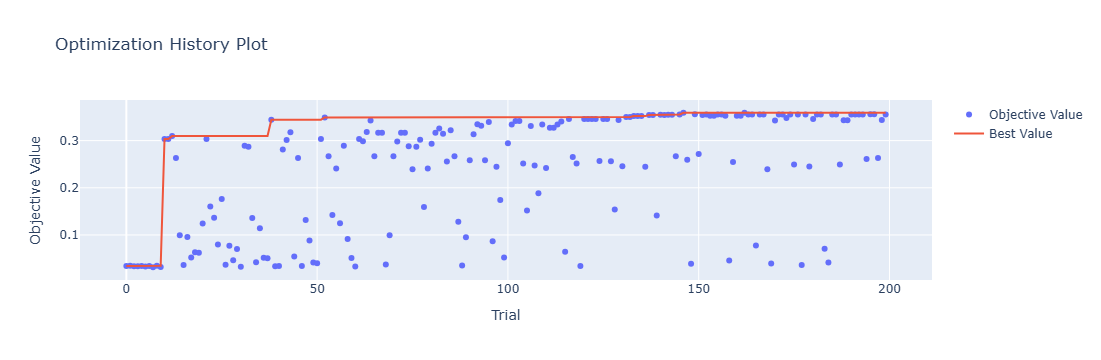

In [41]:
print(study.best_params)
optuna.visualization.plot_optimization_history(study)

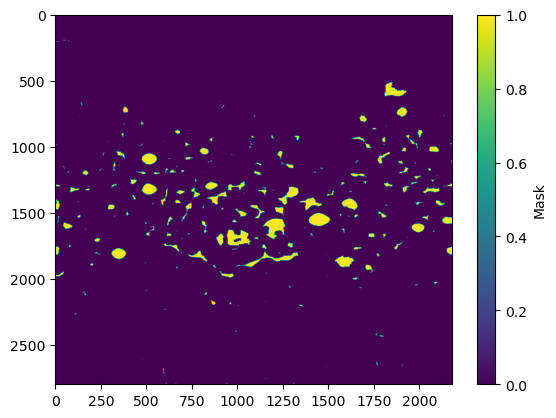

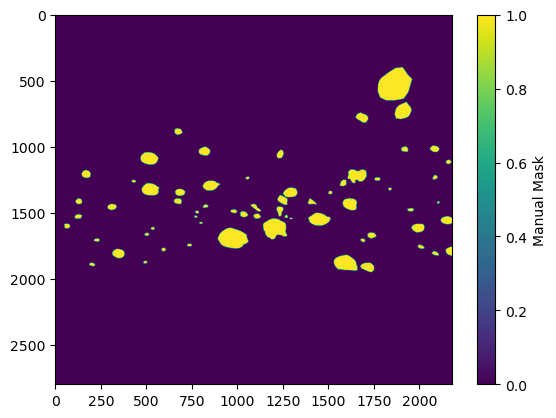

0.359


In [49]:
# Application of adaptive threshold with best parameters (study.best_params)

adaptive_thresh = cv2.adaptiveThreshold(data_clahe, 1, 
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
    cv2.THRESH_BINARY, 
    study.best_params['treshold'],
    study.best_params['const'] 
)

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (study.best_params['kernel_size_close'], study.best_params['kernel_size_close']))
closed = cv2.morphologyEx(adaptive_thresh, cv2.MORPH_CLOSE, kernel)
kernel2 = np.ones((study.best_params['kernel_size_dil'], study.best_params['kernel_size_dil']), dtype=np.uint8)
dilated_AdTr = cv2.erode(closed, kernel2, iterations=1)

plt.imshow(dilated_AdTr, aspect='auto', cmap='viridis')
plt.colorbar(label='Mask') 
plt.show()

plt.imshow(data_man, aspect='auto', cmap='viridis')
plt.colorbar(label='Manual Mask') 
plt.show()

error = jaccard_score(
    data_man.flatten(), 
    dilated_AdTr.flatten(), 
    average='binary'  # For Binary segmentation
    )
print(round(error, 3))

write_ascii_grid(Nx, Ny, xMin, xMax, yMin, yMax, zMin, zMax, dilated_AdTr, '1_OpenCV_Adapt_Thresh.grd')

In [53]:
# 2. Sobel Filter

"""Optimizes Sobel edge detection and morphological operation parameters to maximize Jaccard score.

    This function is used with Optuna to find the best hyperparameters for an image processing pipeline
    that combines Sobel edge detection and morphological operations. The goal is to maximize the Jaccard similarity coefficient (IoU) 
    between the predicted binary mask and the manualy created.

    Args:
        trial (optuna.Trial): An Optuna trial object that suggests hyperparameter values
            for each optimization iteration.

    Returns:
        float: Jaccard score (Intersection over Union) between the predicted edge mask and ground truth.
            The optimizer aims to maximize this value.
"""

def objective_sobel(trial):
    # boundaries for the optimizer's
    ksize= trial.suggest_int("ksize", 3, 7, step=2) # размер ядра
    kernel_size_close = trial.suggest_int("kernel_size_close", 3, 21, step=2) # Kernel size for creating closed figure
    kernel_size_dil = trial.suggest_int("kernel_size_dil", 3, 21, step=2) # Kernel size for creating dilation
    
    sobel_x = cv2.Sobel(data_clahe, cv2.CV_64F, 1, 0, ksize=ksize)
    sobel_y = cv2.Sobel(data_clahe, cv2.CV_64F, 0, 1, ksize=ksize)
    sobel = cv2.magnitude(sobel_x, sobel_y)
    sobel_norm = cv2.normalize(sobel, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    _, sobel_bin = cv2.threshold(sobel_norm, 0, 1, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size_close, kernel_size_close))
    closed = cv2.morphologyEx(sobel_bin, cv2.MORPH_CLOSE, kernel)
    kernel2 = np.ones((kernel_size_dil, kernel_size_dil), dtype=np.uint8)
    final_mask = cv2.erode(closed, kernel2, iterations=1)
  
    error = jaccard_score(
        data_man.flatten(), 
        final_mask.flatten(), 
        average='binary'  # For binary segmentation
    )
    print(error)
    return error

study_sob = optuna.create_study(direction='maximize')  # Maximize IoU
study_sob.optimize(objective_sobel, n_trials = 50)  # Number of iterations

[I 2025-06-05 15:38:25,794] A new study created in memory with name: no-name-113bd5a1-9da0-422f-8f8f-e357989b90d8
[I 2025-06-05 15:38:28,003] Trial 0 finished with value: 0.19466037852835863 and parameters: {'ksize': 7, 'kernel_size_close': 3, 'kernel_size_dil': 17}. Best is trial 0 with value: 0.19466037852835863.


0.19466037852835863


[I 2025-06-05 15:38:30,079] Trial 1 finished with value: 0.09460363400919052 and parameters: {'ksize': 5, 'kernel_size_close': 7, 'kernel_size_dil': 13}. Best is trial 0 with value: 0.19466037852835863.


0.09460363400919052


[I 2025-06-05 15:38:32,096] Trial 2 finished with value: 0.09710632912626023 and parameters: {'ksize': 3, 'kernel_size_close': 5, 'kernel_size_dil': 9}. Best is trial 0 with value: 0.19466037852835863.


0.09710632912626023


[I 2025-06-05 15:38:34,129] Trial 3 finished with value: 0.06634270920204184 and parameters: {'ksize': 7, 'kernel_size_close': 13, 'kernel_size_dil': 11}. Best is trial 0 with value: 0.19466037852835863.


0.06634270920204184


[I 2025-06-05 15:38:36,196] Trial 4 finished with value: 0.0808987430113361 and parameters: {'ksize': 7, 'kernel_size_close': 9, 'kernel_size_dil': 9}. Best is trial 0 with value: 0.19466037852835863.


0.0808987430113361


[I 2025-06-05 15:38:38,257] Trial 5 finished with value: 0.0991478108799493 and parameters: {'ksize': 7, 'kernel_size_close': 7, 'kernel_size_dil': 9}. Best is trial 0 with value: 0.19466037852835863.


0.0991478108799493


[I 2025-06-05 15:38:40,308] Trial 6 finished with value: 0.12274117679764031 and parameters: {'ksize': 5, 'kernel_size_close': 5, 'kernel_size_dil': 13}. Best is trial 0 with value: 0.19466037852835863.


0.12274117679764031


[I 2025-06-05 15:38:42,324] Trial 7 finished with value: 0.08489794517172664 and parameters: {'ksize': 5, 'kernel_size_close': 7, 'kernel_size_dil': 7}. Best is trial 0 with value: 0.19466037852835863.


0.08489794517172664


[I 2025-06-05 15:38:44,417] Trial 8 finished with value: 0.05664301817345296 and parameters: {'ksize': 7, 'kernel_size_close': 21, 'kernel_size_dil': 21}. Best is trial 0 with value: 0.19466037852835863.


0.05664301817345296


[I 2025-06-05 15:38:46,546] Trial 9 finished with value: 0.04716855494240739 and parameters: {'ksize': 3, 'kernel_size_close': 21, 'kernel_size_dil': 21}. Best is trial 0 with value: 0.19466037852835863.


0.04716855494240739


[I 2025-06-05 15:38:48,654] Trial 10 finished with value: 0.06562883290876498 and parameters: {'ksize': 7, 'kernel_size_close': 15, 'kernel_size_dil': 17}. Best is trial 0 with value: 0.19466037852835863.


0.06562883290876498


[I 2025-06-05 15:38:50,724] Trial 11 finished with value: 0.19074714272220647 and parameters: {'ksize': 5, 'kernel_size_close': 3, 'kernel_size_dil': 15}. Best is trial 0 with value: 0.19466037852835863.


0.19074714272220647


[I 2025-06-05 15:38:52,824] Trial 12 finished with value: 0.19512762166543907 and parameters: {'ksize': 5, 'kernel_size_close': 3, 'kernel_size_dil': 17}. Best is trial 12 with value: 0.19512762166543907.


0.19512762166543907


[I 2025-06-05 15:38:54,856] Trial 13 finished with value: 0.13846473029045644 and parameters: {'ksize': 3, 'kernel_size_close': 3, 'kernel_size_dil': 3}. Best is trial 12 with value: 0.19512762166543907.


0.13846473029045644


[I 2025-06-05 15:38:56,919] Trial 14 finished with value: 0.06706365377710348 and parameters: {'ksize': 5, 'kernel_size_close': 11, 'kernel_size_dil': 17}. Best is trial 12 with value: 0.19512762166543907.


0.06706365377710348


[I 2025-06-05 15:38:58,984] Trial 15 finished with value: 0.05417771015207283 and parameters: {'ksize': 5, 'kernel_size_close': 17, 'kernel_size_dil': 17}. Best is trial 12 with value: 0.19512762166543907.


0.05417771015207283


[I 2025-06-05 15:39:01,084] Trial 16 finished with value: 0.19911554789236496 and parameters: {'ksize': 7, 'kernel_size_close': 3, 'kernel_size_dil': 19}. Best is trial 16 with value: 0.19911554789236496.


0.19911554789236496


[I 2025-06-05 15:39:03,121] Trial 17 finished with value: 0.06071079653203002 and parameters: {'ksize': 3, 'kernel_size_close': 11, 'kernel_size_dil': 19}. Best is trial 16 with value: 0.19911554789236496.


0.06071079653203002


[I 2025-06-05 15:39:05,173] Trial 18 finished with value: 0.1391404333670602 and parameters: {'ksize': 5, 'kernel_size_close': 5, 'kernel_size_dil': 19}. Best is trial 16 with value: 0.19911554789236496.


0.1391404333670602


[I 2025-06-05 15:39:07,231] Trial 19 finished with value: 0.09079599292177074 and parameters: {'ksize': 7, 'kernel_size_close': 9, 'kernel_size_dil': 15}. Best is trial 16 with value: 0.19911554789236496.


0.09079599292177074


[I 2025-06-05 15:39:09,290] Trial 20 finished with value: 0.0548493662944879 and parameters: {'ksize': 5, 'kernel_size_close': 17, 'kernel_size_dil': 19}. Best is trial 16 with value: 0.19911554789236496.


0.0548493662944879


[I 2025-06-05 15:39:11,300] Trial 21 finished with value: 0.18957009219306228 and parameters: {'ksize': 7, 'kernel_size_close': 3, 'kernel_size_dil': 15}. Best is trial 16 with value: 0.19911554789236496.


0.18957009219306228


[I 2025-06-05 15:39:13,334] Trial 22 finished with value: 0.20277299140285593 and parameters: {'ksize': 7, 'kernel_size_close': 3, 'kernel_size_dil': 21}. Best is trial 22 with value: 0.20277299140285593.


0.20277299140285593


[I 2025-06-05 15:39:15,401] Trial 23 finished with value: 0.16186348166698775 and parameters: {'ksize': 7, 'kernel_size_close': 5, 'kernel_size_dil': 21}. Best is trial 22 with value: 0.20277299140285593.


0.16186348166698775


[I 2025-06-05 15:39:17,519] Trial 24 finished with value: 0.19911554789236496 and parameters: {'ksize': 7, 'kernel_size_close': 3, 'kernel_size_dil': 19}. Best is trial 22 with value: 0.20277299140285593.


0.19911554789236496


[I 2025-06-05 15:39:19,623] Trial 25 finished with value: 0.12928073458984704 and parameters: {'ksize': 7, 'kernel_size_close': 7, 'kernel_size_dil': 21}. Best is trial 22 with value: 0.20277299140285593.


0.12928073458984704


[I 2025-06-05 15:39:21,712] Trial 26 finished with value: 0.09787093115196575 and parameters: {'ksize': 7, 'kernel_size_close': 9, 'kernel_size_dil': 19}. Best is trial 22 with value: 0.20277299140285593.


0.09787093115196575


[I 2025-06-05 15:39:23,789] Trial 27 finished with value: 0.1563346806767004 and parameters: {'ksize': 7, 'kernel_size_close': 5, 'kernel_size_dil': 19}. Best is trial 22 with value: 0.20277299140285593.


0.1563346806767004


[I 2025-06-05 15:39:25,928] Trial 28 finished with value: 0.20277299140285593 and parameters: {'ksize': 7, 'kernel_size_close': 3, 'kernel_size_dil': 21}. Best is trial 22 with value: 0.20277299140285593.


0.20277299140285593


[I 2025-06-05 15:39:27,995] Trial 29 finished with value: 0.20277299140285593 and parameters: {'ksize': 7, 'kernel_size_close': 3, 'kernel_size_dil': 21}. Best is trial 22 with value: 0.20277299140285593.


0.20277299140285593


[I 2025-06-05 15:39:30,041] Trial 30 finished with value: 0.16186348166698775 and parameters: {'ksize': 7, 'kernel_size_close': 5, 'kernel_size_dil': 21}. Best is trial 22 with value: 0.20277299140285593.


0.16186348166698775


[I 2025-06-05 15:39:32,071] Trial 31 finished with value: 0.20277299140285593 and parameters: {'ksize': 7, 'kernel_size_close': 3, 'kernel_size_dil': 21}. Best is trial 22 with value: 0.20277299140285593.


0.20277299140285593


[I 2025-06-05 15:39:34,174] Trial 32 finished with value: 0.20277299140285593 and parameters: {'ksize': 7, 'kernel_size_close': 3, 'kernel_size_dil': 21}. Best is trial 22 with value: 0.20277299140285593.


0.20277299140285593


[I 2025-06-05 15:39:36,248] Trial 33 finished with value: 0.12928073458984704 and parameters: {'ksize': 7, 'kernel_size_close': 7, 'kernel_size_dil': 21}. Best is trial 22 with value: 0.20277299140285593.


0.12928073458984704


[I 2025-06-05 15:39:38,342] Trial 34 finished with value: 0.1504377124075246 and parameters: {'ksize': 7, 'kernel_size_close': 5, 'kernel_size_dil': 17}. Best is trial 22 with value: 0.20277299140285593.


0.1504377124075246


[I 2025-06-05 15:39:40,386] Trial 35 finished with value: 0.10556590684942119 and parameters: {'ksize': 7, 'kernel_size_close': 5, 'kernel_size_dil': 3}. Best is trial 22 with value: 0.20277299140285593.


0.10556590684942119


[I 2025-06-05 15:39:42,433] Trial 36 finished with value: 0.12928073458984704 and parameters: {'ksize': 7, 'kernel_size_close': 7, 'kernel_size_dil': 21}. Best is trial 22 with value: 0.20277299140285593.


0.12928073458984704


[I 2025-06-05 15:39:44,497] Trial 37 finished with value: 0.18393335667333055 and parameters: {'ksize': 7, 'kernel_size_close': 3, 'kernel_size_dil': 13}. Best is trial 22 with value: 0.20277299140285593.


0.18393335667333055


[I 2025-06-05 15:39:46,556] Trial 38 finished with value: 0.07784920037692428 and parameters: {'ksize': 7, 'kernel_size_close': 9, 'kernel_size_dil': 7}. Best is trial 22 with value: 0.20277299140285593.


0.07784920037692428


[I 2025-06-05 15:39:48,672] Trial 39 finished with value: 0.1563346806767004 and parameters: {'ksize': 7, 'kernel_size_close': 5, 'kernel_size_dil': 19}. Best is trial 22 with value: 0.20277299140285593.


0.1563346806767004


[I 2025-06-05 15:39:50,758] Trial 40 finished with value: 0.06634270920204184 and parameters: {'ksize': 7, 'kernel_size_close': 13, 'kernel_size_dil': 11}. Best is trial 22 with value: 0.20277299140285593.


0.06634270920204184


[I 2025-06-05 15:39:52,855] Trial 41 finished with value: 0.20277299140285593 and parameters: {'ksize': 7, 'kernel_size_close': 3, 'kernel_size_dil': 21}. Best is trial 22 with value: 0.20277299140285593.


0.20277299140285593


[I 2025-06-05 15:39:54,906] Trial 42 finished with value: 0.20277299140285593 and parameters: {'ksize': 7, 'kernel_size_close': 3, 'kernel_size_dil': 21}. Best is trial 22 with value: 0.20277299140285593.


0.20277299140285593


[I 2025-06-05 15:39:56,970] Trial 43 finished with value: 0.16186348166698775 and parameters: {'ksize': 7, 'kernel_size_close': 5, 'kernel_size_dil': 21}. Best is trial 22 with value: 0.20277299140285593.


0.16186348166698775


[I 2025-06-05 15:39:59,029] Trial 44 finished with value: 0.12413461120601184 and parameters: {'ksize': 7, 'kernel_size_close': 7, 'kernel_size_dil': 19}. Best is trial 22 with value: 0.20277299140285593.


0.12413461120601184


[I 2025-06-05 15:40:01,076] Trial 45 finished with value: 0.20277299140285593 and parameters: {'ksize': 7, 'kernel_size_close': 3, 'kernel_size_dil': 21}. Best is trial 22 with value: 0.20277299140285593.


0.20277299140285593


[I 2025-06-05 15:40:03,113] Trial 46 finished with value: 0.19512762166543907 and parameters: {'ksize': 5, 'kernel_size_close': 3, 'kernel_size_dil': 17}. Best is trial 22 with value: 0.20277299140285593.


0.19512762166543907


[I 2025-06-05 15:40:05,222] Trial 47 finished with value: 0.16186348166698775 and parameters: {'ksize': 7, 'kernel_size_close': 5, 'kernel_size_dil': 21}. Best is trial 22 with value: 0.20277299140285593.


0.16186348166698775


[I 2025-06-05 15:40:07,307] Trial 48 finished with value: 0.09051889860259216 and parameters: {'ksize': 7, 'kernel_size_close': 7, 'kernel_size_dil': 5}. Best is trial 22 with value: 0.20277299140285593.


0.09051889860259216


[I 2025-06-05 15:40:09,364] Trial 49 finished with value: 0.19512762166543907 and parameters: {'ksize': 5, 'kernel_size_close': 3, 'kernel_size_dil': 17}. Best is trial 22 with value: 0.20277299140285593.


0.19512762166543907


{'ksize': 7, 'kernel_size_close': 3, 'kernel_size_dil': 21}


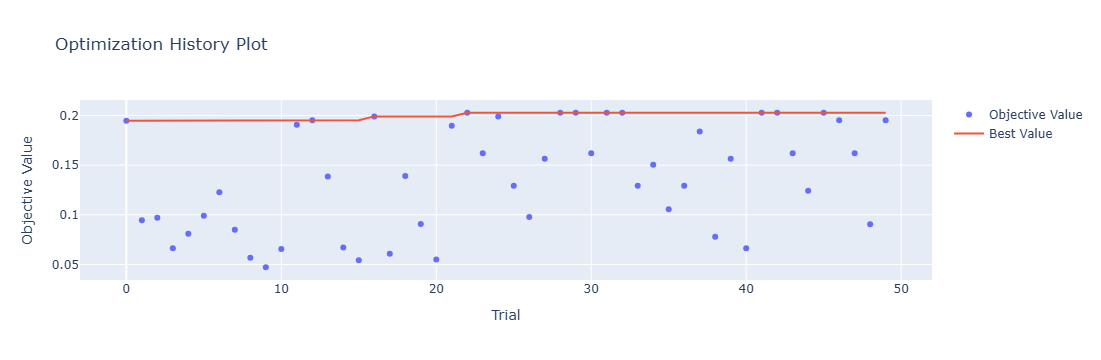

In [54]:
print(study_sob.best_params)
optuna.visualization.plot_optimization_history(study_sob)

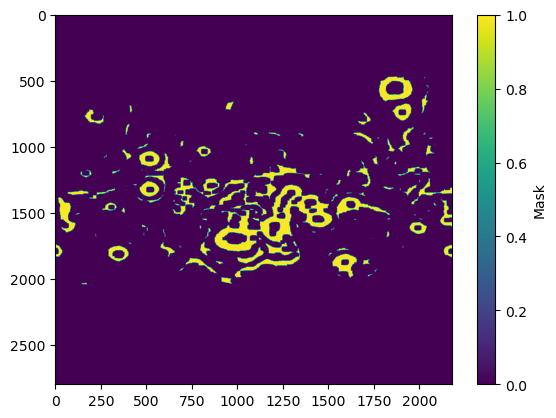

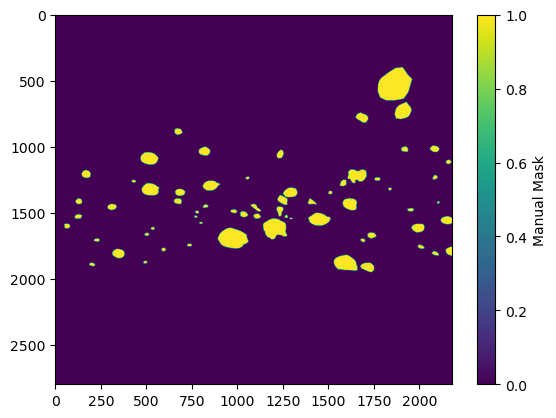

0.203


In [59]:
# Application of Sobel filter with best parameters (study.best_params)

sobel_x = cv2.Sobel(data_clahe, cv2.CV_64F, 1, 0, ksize=study_sob.best_params['ksize'])
sobel_y = cv2.Sobel(data_clahe, cv2.CV_64F, 0, 1, ksize=study_sob.best_params['ksize'])
sobel = cv2.magnitude(sobel_x, sobel_y)
sobel = cv2.normalize(sobel, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
_, sobel_bin = cv2.threshold(sobel, 0, 1, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (study_sob.best_params['kernel_size_close'], study_sob.best_params['kernel_size_close']))
closed = cv2.morphologyEx(sobel_bin, cv2.MORPH_CLOSE, kernel)
kernel2 = np.ones((study_sob.best_params['kernel_size_dil'], study_sob.best_params['kernel_size_dil']), dtype=np.uint8)
dilated_sob = cv2.erode(closed, kernel2, iterations=1)

plt.imshow(dilated_sob, aspect='auto', cmap='viridis')
plt.colorbar(label='Mask') 
plt.show()

plt.imshow(data_man, aspect='auto', cmap='viridis')
plt.colorbar(label='Manual Mask') 
plt.show()

error = jaccard_score(
    data_man.flatten(), 
    dilated_sob.flatten(), 
    average='binary'  # For binary segmentation
    )
print(round(error, 3))

write_ascii_grid(Nx, Ny, xMin, xMax, yMin, yMax, zMin, zMax, dilated_sob, '1_OpenCV_Sobel.grd')

In [65]:
# 3. Lapalce Operator

"""Optimizes Laplacian edge detection and morphological operation parameters to maximize Jaccard score.

    This function is used with Optuna to find the best hyperparameters for an image processing pipeline
    that combines Lapalace operator and morphological operations. The goal is to maximize the Jaccard similarity coefficient (IoU) 
    between the predicted binary mask and the manualy created.

    Args:
        trial (optuna.Trial): An Optuna trial object that suggests hyperparameter values
            for each optimization iteration.

    Returns:
        float: Jaccard score (Intersection over Union) between the predicted edge mask and the manualy created mask.
            The optimizer aims to maximize this value.
"""


def objective_laplace(trial):
    # boundaries for the optimizer's
    ksize= trial.suggest_int("ksize", 11, 31, step=2) # Laplace filter kernel size
    kernel_size_close = trial.suggest_int("kernel_size_close", 3, 21, step=2) # Kernel size for creating closed figure
    kernel_size_dil = trial.suggest_int("kernel_size_dil", 3, 21, step=2) # Kernel size for creating dilation
    
    laplace = cv2.Laplacian(data_clahe, cv2.CV_64F, ksize=ksize)
    laplace = 1- cv2.normalize(laplace, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    _, laplace_bin = cv2.threshold(laplace, 0, 1, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size_close, kernel_size_close))
    closed = cv2.morphologyEx(laplace_bin, cv2.MORPH_CLOSE, kernel)
    kernel2 = np.ones((kernel_size_dil, kernel_size_dil), dtype=np.uint8)
    final_mask = cv2.erode(closed, kernel2, iterations=1)
  
    error = jaccard_score(
        data_man.flatten(), 
        final_mask.flatten(), 
        average='binary'  # For binary segmentation
    )
    print(error)
    return error

study_lap = optuna.create_study(direction='maximize')  # Maximize IoU
study_lap.optimize(objective_laplace, n_trials = 50)  # Number of iteration

[I 2025-06-05 15:44:43,605] A new study created in memory with name: no-name-dfb2273b-7c84-4071-a977-baf59b8d0c95
[I 2025-06-05 15:44:45,554] Trial 0 finished with value: 0.032738964387781934 and parameters: {'ksize': 29, 'kernel_size_close': 13, 'kernel_size_dil': 21}. Best is trial 0 with value: 0.032738964387781934.


0.032738964387781934


[I 2025-06-05 15:44:47,513] Trial 1 finished with value: 0.06629225700960927 and parameters: {'ksize': 21, 'kernel_size_close': 5, 'kernel_size_dil': 11}. Best is trial 1 with value: 0.06629225700960927.


0.06629225700960927


[I 2025-06-05 15:44:49,453] Trial 2 finished with value: 0.032097252808566554 and parameters: {'ksize': 17, 'kernel_size_close': 13, 'kernel_size_dil': 21}. Best is trial 1 with value: 0.06629225700960927.


0.032097252808566554


[I 2025-06-05 15:44:51,432] Trial 3 finished with value: 0.03819317065427401 and parameters: {'ksize': 29, 'kernel_size_close': 9, 'kernel_size_dil': 15}. Best is trial 1 with value: 0.06629225700960927.


0.03819317065427401


[I 2025-06-05 15:44:53,453] Trial 4 finished with value: 0.03304304257390764 and parameters: {'ksize': 25, 'kernel_size_close': 13, 'kernel_size_dil': 19}. Best is trial 1 with value: 0.06629225700960927.


0.03304304257390764


[I 2025-06-05 15:44:55,406] Trial 5 finished with value: 0.16636325275785158 and parameters: {'ksize': 23, 'kernel_size_close': 3, 'kernel_size_dil': 15}. Best is trial 5 with value: 0.16636325275785158.


0.16636325275785158


[I 2025-06-05 15:44:57,361] Trial 6 finished with value: 0.03352984457481964 and parameters: {'ksize': 25, 'kernel_size_close': 15, 'kernel_size_dil': 17}. Best is trial 5 with value: 0.16636325275785158.


0.03352984457481964


[I 2025-06-05 15:44:59,356] Trial 7 finished with value: 0.033854996918564015 and parameters: {'ksize': 27, 'kernel_size_close': 21, 'kernel_size_dil': 3}. Best is trial 5 with value: 0.16636325275785158.


0.033854996918564015


[I 2025-06-05 15:45:01,315] Trial 8 finished with value: 0.033488072524669475 and parameters: {'ksize': 19, 'kernel_size_close': 13, 'kernel_size_dil': 13}. Best is trial 5 with value: 0.16636325275785158.


0.033488072524669475


[I 2025-06-05 15:45:03,297] Trial 9 finished with value: 0.03289079100938889 and parameters: {'ksize': 15, 'kernel_size_close': 21, 'kernel_size_dil': 3}. Best is trial 5 with value: 0.16636325275785158.


0.03289079100938889


[I 2025-06-05 15:45:05,253] Trial 10 finished with value: 0.09299065246049797 and parameters: {'ksize': 13, 'kernel_size_close': 3, 'kernel_size_dil': 9}. Best is trial 5 with value: 0.16636325275785158.


0.09299065246049797


[I 2025-06-05 15:45:07,202] Trial 11 finished with value: 0.07927570365759791 and parameters: {'ksize': 11, 'kernel_size_close': 3, 'kernel_size_dil': 9}. Best is trial 5 with value: 0.16636325275785158.


0.07927570365759791


[I 2025-06-05 15:45:09,140] Trial 12 finished with value: 0.0330680312529594 and parameters: {'ksize': 11, 'kernel_size_close': 7, 'kernel_size_dil': 7}. Best is trial 5 with value: 0.16636325275785158.


0.0330680312529594


[I 2025-06-05 15:45:11,132] Trial 13 finished with value: 0.09129822492766737 and parameters: {'ksize': 23, 'kernel_size_close': 3, 'kernel_size_dil': 7}. Best is trial 5 with value: 0.16636325275785158.


0.09129822492766737


[I 2025-06-05 15:45:13,192] Trial 14 finished with value: 0.033020215865617805 and parameters: {'ksize': 15, 'kernel_size_close': 9, 'kernel_size_dil': 13}. Best is trial 5 with value: 0.16636325275785158.


0.033020215865617805


[I 2025-06-05 15:45:15,148] Trial 15 finished with value: 0.04105126891085849 and parameters: {'ksize': 21, 'kernel_size_close': 7, 'kernel_size_dil': 9}. Best is trial 5 with value: 0.16636325275785158.


0.04105126891085849


[I 2025-06-05 15:45:17,148] Trial 16 finished with value: 0.16501999120337352 and parameters: {'ksize': 31, 'kernel_size_close': 3, 'kernel_size_dil': 15}. Best is trial 5 with value: 0.16636325275785158.


0.16501999120337352


[I 2025-06-05 15:45:19,240] Trial 17 finished with value: 0.03414344358475651 and parameters: {'ksize': 31, 'kernel_size_close': 17, 'kernel_size_dil': 17}. Best is trial 5 with value: 0.16636325275785158.


0.03414344358475651


[I 2025-06-05 15:45:21,248] Trial 18 finished with value: 0.0676116752824643 and parameters: {'ksize': 31, 'kernel_size_close': 7, 'kernel_size_dil': 17}. Best is trial 5 with value: 0.16636325275785158.


0.0676116752824643


[I 2025-06-05 15:45:23,265] Trial 19 finished with value: 0.09095782869418352 and parameters: {'ksize': 27, 'kernel_size_close': 5, 'kernel_size_dil': 15}. Best is trial 5 with value: 0.16636325275785158.


0.09095782869418352


[I 2025-06-05 15:45:25,248] Trial 20 finished with value: 0.03451139718945658 and parameters: {'ksize': 23, 'kernel_size_close': 9, 'kernel_size_dil': 15}. Best is trial 5 with value: 0.16636325275785158.


0.03451139718945658


[I 2025-06-05 15:45:27,234] Trial 21 finished with value: 0.1057366949698294 and parameters: {'ksize': 13, 'kernel_size_close': 3, 'kernel_size_dil': 11}. Best is trial 5 with value: 0.16636325275785158.


0.1057366949698294


[I 2025-06-05 15:45:29,145] Trial 22 finished with value: 0.06469648995873688 and parameters: {'ksize': 19, 'kernel_size_close': 5, 'kernel_size_dil': 11}. Best is trial 5 with value: 0.16636325275785158.


0.06469648995873688


[I 2025-06-05 15:45:31,117] Trial 23 finished with value: 0.15133109656844831 and parameters: {'ksize': 17, 'kernel_size_close': 3, 'kernel_size_dil': 13}. Best is trial 5 with value: 0.16636325275785158.


0.15133109656844831


[I 2025-06-05 15:45:33,081] Trial 24 finished with value: 0.06727187536123497 and parameters: {'ksize': 17, 'kernel_size_close': 5, 'kernel_size_dil': 13}. Best is trial 5 with value: 0.16636325275785158.


0.06727187536123497


[I 2025-06-05 15:45:35,050] Trial 25 finished with value: 0.1944490912284517 and parameters: {'ksize': 19, 'kernel_size_close': 3, 'kernel_size_dil': 19}. Best is trial 25 with value: 0.1944490912284517.


0.1944490912284517


[I 2025-06-05 15:45:37,003] Trial 26 finished with value: 0.047979091080410055 and parameters: {'ksize': 21, 'kernel_size_close': 7, 'kernel_size_dil': 19}. Best is trial 25 with value: 0.1944490912284517.


0.047979091080410055


[I 2025-06-05 15:45:38,980] Trial 27 finished with value: 0.09117263075522579 and parameters: {'ksize': 23, 'kernel_size_close': 5, 'kernel_size_dil': 19}. Best is trial 25 with value: 0.1944490912284517.


0.09117263075522579


[I 2025-06-05 15:45:40,942] Trial 28 finished with value: 0.032956082522704426 and parameters: {'ksize': 19, 'kernel_size_close': 9, 'kernel_size_dil': 17}. Best is trial 25 with value: 0.1944490912284517.


0.032956082522704426


[I 2025-06-05 15:45:42,956] Trial 29 finished with value: 0.03288952825102337 and parameters: {'ksize': 27, 'kernel_size_close': 11, 'kernel_size_dil': 21}. Best is trial 25 with value: 0.1944490912284517.


0.03288952825102337


[I 2025-06-05 15:45:44,942] Trial 30 finished with value: 0.0341798905620256 and parameters: {'ksize': 29, 'kernel_size_close': 17, 'kernel_size_dil': 15}. Best is trial 25 with value: 0.1944490912284517.


0.0341798905620256


[I 2025-06-05 15:45:46,928] Trial 31 finished with value: 0.15133109656844831 and parameters: {'ksize': 17, 'kernel_size_close': 3, 'kernel_size_dil': 13}. Best is trial 25 with value: 0.1944490912284517.


0.15133109656844831


[I 2025-06-05 15:45:48,897] Trial 32 finished with value: 0.14416481141358287 and parameters: {'ksize': 15, 'kernel_size_close': 3, 'kernel_size_dil': 15}. Best is trial 25 with value: 0.1944490912284517.


0.14416481141358287


[I 2025-06-05 15:45:50,897] Trial 33 finished with value: 0.08512978719954943 and parameters: {'ksize': 19, 'kernel_size_close': 5, 'kernel_size_dil': 19}. Best is trial 25 with value: 0.1944490912284517.


0.08512978719954943


[I 2025-06-05 15:45:52,877] Trial 34 finished with value: 0.19849147890115829 and parameters: {'ksize': 17, 'kernel_size_close': 3, 'kernel_size_dil': 21}. Best is trial 34 with value: 0.19849147890115829.


0.19849147890115829


[I 2025-06-05 15:45:54,836] Trial 35 finished with value: 0.09285637604801007 and parameters: {'ksize': 21, 'kernel_size_close': 5, 'kernel_size_dil': 21}. Best is trial 34 with value: 0.19849147890115829.


0.09285637604801007


[I 2025-06-05 15:45:56,848] Trial 36 finished with value: 0.058867726075648 and parameters: {'ksize': 25, 'kernel_size_close': 7, 'kernel_size_dil': 21}. Best is trial 34 with value: 0.19849147890115829.


0.058867726075648


[I 2025-06-05 15:45:58,893] Trial 37 finished with value: 0.033919704940444745 and parameters: {'ksize': 29, 'kernel_size_close': 11, 'kernel_size_dil': 19}. Best is trial 34 with value: 0.19849147890115829.


0.033919704940444745


[I 2025-06-05 15:46:00,869] Trial 38 finished with value: 0.08286260783249462 and parameters: {'ksize': 21, 'kernel_size_close': 5, 'kernel_size_dil': 17}. Best is trial 34 with value: 0.19849147890115829.


0.08286260783249462


[I 2025-06-05 15:46:02,904] Trial 39 finished with value: 0.19605341631012577 and parameters: {'ksize': 25, 'kernel_size_close': 3, 'kernel_size_dil': 19}. Best is trial 34 with value: 0.19849147890115829.


0.19605341631012577


[I 2025-06-05 15:46:04,887] Trial 40 finished with value: 0.09117263075522579 and parameters: {'ksize': 23, 'kernel_size_close': 5, 'kernel_size_dil': 19}. Best is trial 34 with value: 0.19849147890115829.


0.09117263075522579


[I 2025-06-05 15:46:06,932] Trial 41 finished with value: 0.20982219301913466 and parameters: {'ksize': 25, 'kernel_size_close': 3, 'kernel_size_dil': 21}. Best is trial 41 with value: 0.20982219301913466.


0.20982219301913466


[I 2025-06-05 15:46:09,030] Trial 42 finished with value: 0.20982219301913466 and parameters: {'ksize': 25, 'kernel_size_close': 3, 'kernel_size_dil': 21}. Best is trial 41 with value: 0.20982219301913466.


0.20982219301913466


[I 2025-06-05 15:46:11,035] Trial 43 finished with value: 0.20982219301913466 and parameters: {'ksize': 25, 'kernel_size_close': 3, 'kernel_size_dil': 21}. Best is trial 41 with value: 0.20982219301913466.


0.20982219301913466


[I 2025-06-05 15:46:13,098] Trial 44 finished with value: 0.09946986277680987 and parameters: {'ksize': 25, 'kernel_size_close': 5, 'kernel_size_dil': 21}. Best is trial 41 with value: 0.20982219301913466.


0.09946986277680987


[I 2025-06-05 15:46:15,110] Trial 45 finished with value: 0.20982219301913466 and parameters: {'ksize': 25, 'kernel_size_close': 3, 'kernel_size_dil': 21}. Best is trial 41 with value: 0.20982219301913466.


0.20982219301913466


[I 2025-06-05 15:46:17,093] Trial 46 finished with value: 0.22605148433987224 and parameters: {'ksize': 27, 'kernel_size_close': 3, 'kernel_size_dil': 21}. Best is trial 46 with value: 0.22605148433987224.


0.22605148433987224


[I 2025-06-05 15:46:19,072] Trial 47 finished with value: 0.0681393413600379 and parameters: {'ksize': 27, 'kernel_size_close': 7, 'kernel_size_dil': 21}. Best is trial 46 with value: 0.22605148433987224.


0.0681393413600379


[I 2025-06-05 15:46:21,051] Trial 48 finished with value: 0.03279629709217202 and parameters: {'ksize': 27, 'kernel_size_close': 15, 'kernel_size_dil': 21}. Best is trial 46 with value: 0.22605148433987224.


0.03279629709217202


[I 2025-06-05 15:46:23,027] Trial 49 finished with value: 0.20982219301913466 and parameters: {'ksize': 25, 'kernel_size_close': 3, 'kernel_size_dil': 21}. Best is trial 46 with value: 0.22605148433987224.


0.20982219301913466


{'ksize': 27, 'kernel_size_close': 3, 'kernel_size_dil': 21}


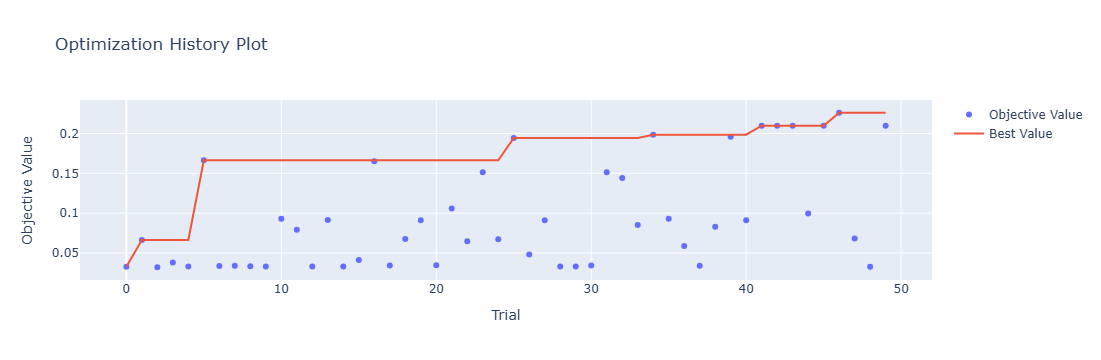

In [66]:
print(study_lap.best_params)
optuna.visualization.plot_optimization_history(study_lap)

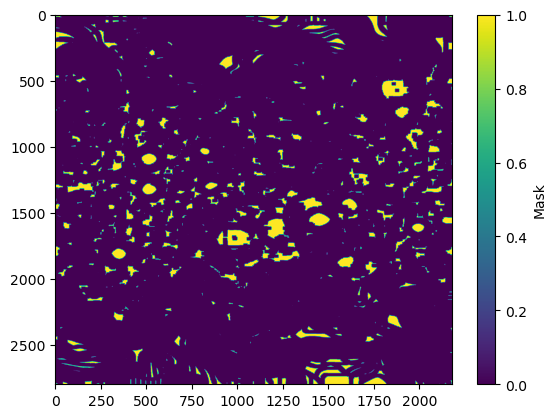

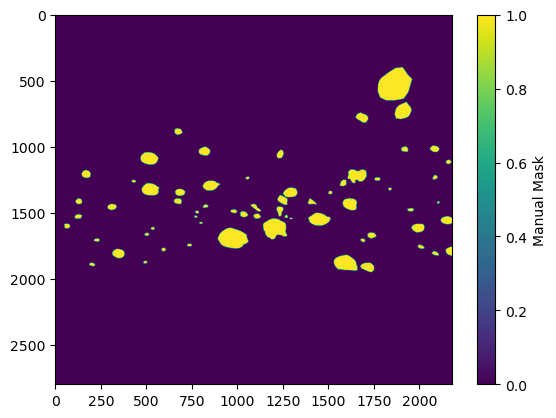

0.226


In [71]:
# Application of Lapalce operator with best parameters (study.best_params)

laplace = cv2.Laplacian(data_clahe, cv2.CV_64F, ksize=study_lap.best_params['ksize'])

laplace = 1-cv2.normalize(laplace, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
_, laplace_bin = cv2.threshold(laplace, 0, 1, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (study_lap.best_params['kernel_size_close'], study_lap.best_params['kernel_size_close']))
closed = cv2.morphologyEx(laplace_bin, cv2.MORPH_CLOSE, kernel)
kernel2 = np.ones((study_lap.best_params['kernel_size_dil'], study_lap.best_params['kernel_size_dil']), dtype=np.uint8)
dilated_lap = cv2.erode(closed, kernel2, iterations=1)

plt.imshow(dilated_lap, aspect='auto', cmap='viridis')
plt.colorbar(label='Mask') 
plt.show()

plt.imshow(data_man, aspect='auto', cmap='viridis')
plt.colorbar(label='Manual Mask') 
plt.show()

error = jaccard_score(
    data_man.flatten(), 
    dilated_lap.flatten(), 
    average='binary'  # For binary segmentation
    )
print(round(error, 3))

write_ascii_grid(Nx, Ny, xMin, xMax, yMin, yMax, zMin, zMax, dilated_lap, '1_OpenCV_Laplace.grd')

In [73]:
# 4. Canny detector

"""Optimizes Canny edge detector and morphological operation parameters to maximize Jaccard score.

    This function is used with Optuna to find the best hyperparameters for an image processing pipeline
    that combines Canny edge detector and morphological operations. The goal is to maximize the Jaccard similarity coefficient (IoU) 
    between the predicted binary mask and the manualy created.

    Args:
        trial (optuna.Trial): An Optuna trial object that suggests hyperparameter values
            for each optimization iteration.

    Returns:
        float: Jaccard score (Intersection over Union) between the predicted edge mask and the manualy created mask.
            The optimizer aims to maximize this value.
"""

def objective_canny(trial):
    # boundaries for the optimizer's
    threshold1 = trial.suggest_int("tr1", 0, 5, step=1) # Treshold 1
    threshold2 = trial.suggest_int("tr2", 11, 51, step=2) # Treshold 2
    kernel_size_close = trial.suggest_int("kernel_size_close", 3, 31, step=2) # Kernel size for creating closed figure
    kernel_size_dil = trial.suggest_int("kernel_size_dil", 3, 31, step=2) # Kernel size for creating dilation
    
    canny = cv2.Canny(data_clahe, threshold1 =  threshold1, threshold2 = threshold2)
    canny = cv2.normalize(canny, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    _, canny_bin = cv2.threshold(canny, 0, 1, cv2.THRESH_BINARY)
    
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size_close, kernel_size_close))
    closed = cv2.morphologyEx(canny_bin, cv2.MORPH_CLOSE, kernel)
    kernel2 = np.ones((kernel_size_dil, kernel_size_dil), dtype=np.uint8)
    final_mask = cv2.erode(closed, kernel2, iterations=1)
  
    error = jaccard_score(
        data_man.flatten(), 
        final_mask.flatten(), 
        average='binary'  # For binary segmentation
    )
    print(error)
    return error

study_canny = optuna.create_study(direction='maximize')
study_canny.optimize(objective_canny, n_trials = 50)

[I 2025-06-05 15:46:45,002] A new study created in memory with name: no-name-796fead1-13e4-455c-873f-a37546667846
[I 2025-06-05 15:46:46,958] Trial 0 finished with value: 0.001811753731951769 and parameters: {'tr1': 5, 'tr2': 51, 'kernel_size_close': 23, 'kernel_size_dil': 23}. Best is trial 0 with value: 0.001811753731951769.


0.001811753731951769


[I 2025-06-05 15:46:48,808] Trial 1 finished with value: 0.018580899228773325 and parameters: {'tr1': 4, 'tr2': 43, 'kernel_size_close': 7, 'kernel_size_dil': 11}. Best is trial 1 with value: 0.018580899228773325.


0.018580899228773325


[I 2025-06-05 15:46:50,729] Trial 2 finished with value: 0.006485071232465927 and parameters: {'tr1': 2, 'tr2': 47, 'kernel_size_close': 19, 'kernel_size_dil': 7}. Best is trial 1 with value: 0.018580899228773325.


0.006485071232465927


[I 2025-06-05 15:46:52,692] Trial 3 finished with value: 0.005703207528284938 and parameters: {'tr1': 0, 'tr2': 45, 'kernel_size_close': 27, 'kernel_size_dil': 25}. Best is trial 1 with value: 0.018580899228773325.


0.005703207528284938


[I 2025-06-05 15:46:54,593] Trial 4 finished with value: 0.01801554574669919 and parameters: {'tr1': 2, 'tr2': 35, 'kernel_size_close': 15, 'kernel_size_dil': 27}. Best is trial 1 with value: 0.018580899228773325.


0.01801554574669919


[I 2025-06-05 15:46:56,491] Trial 5 finished with value: 0.029751094949727663 and parameters: {'tr1': 1, 'tr2': 25, 'kernel_size_close': 15, 'kernel_size_dil': 21}. Best is trial 5 with value: 0.029751094949727663.


0.029751094949727663


[I 2025-06-05 15:46:58,305] Trial 6 finished with value: 0.046268739550597654 and parameters: {'tr1': 2, 'tr2': 19, 'kernel_size_close': 5, 'kernel_size_dil': 21}. Best is trial 6 with value: 0.046268739550597654.


0.046268739550597654


[I 2025-06-05 15:47:00,349] Trial 7 finished with value: 0.03997320113541482 and parameters: {'tr1': 5, 'tr2': 17, 'kernel_size_close': 31, 'kernel_size_dil': 11}. Best is trial 6 with value: 0.046268739550597654.


0.03997320113541482


[I 2025-06-05 15:47:02,285] Trial 8 finished with value: 0.055621838773606984 and parameters: {'tr1': 5, 'tr2': 13, 'kernel_size_close': 15, 'kernel_size_dil': 31}. Best is trial 8 with value: 0.055621838773606984.


0.055621838773606984


[I 2025-06-05 15:47:04,251] Trial 9 finished with value: 0.02294035607219246 and parameters: {'tr1': 3, 'tr2': 29, 'kernel_size_close': 17, 'kernel_size_dil': 25}. Best is trial 8 with value: 0.055621838773606984.


0.02294035607219246


[I 2025-06-05 15:47:06,155] Trial 10 finished with value: 0.07367801690551765 and parameters: {'tr1': 4, 'tr2': 11, 'kernel_size_close': 11, 'kernel_size_dil': 31}. Best is trial 10 with value: 0.07367801690551765.


0.07367801690551765


[I 2025-06-05 15:47:08,119] Trial 11 finished with value: 0.08133178801480546 and parameters: {'tr1': 4, 'tr2': 11, 'kernel_size_close': 9, 'kernel_size_dil': 31}. Best is trial 11 with value: 0.08133178801480546.


0.08133178801480546


[I 2025-06-05 15:47:10,068] Trial 12 finished with value: 0.07367801690551765 and parameters: {'tr1': 4, 'tr2': 11, 'kernel_size_close': 11, 'kernel_size_dil': 31}. Best is trial 11 with value: 0.08133178801480546.


0.07367801690551765


[I 2025-06-05 15:47:11,970] Trial 13 finished with value: 0.04524577434028528 and parameters: {'tr1': 4, 'tr2': 23, 'kernel_size_close': 9, 'kernel_size_dil': 17}. Best is trial 11 with value: 0.08133178801480546.


0.04524577434028528


[I 2025-06-05 15:47:13,837] Trial 14 finished with value: 0.0 and parameters: {'tr1': 3, 'tr2': 11, 'kernel_size_close': 3, 'kernel_size_dil': 31}. Best is trial 11 with value: 0.08133178801480546.


0.0


[I 2025-06-05 15:47:15,727] Trial 15 finished with value: 0.012615562100974793 and parameters: {'tr1': 4, 'tr2': 37, 'kernel_size_close': 11, 'kernel_size_dil': 17}. Best is trial 11 with value: 0.08133178801480546.


0.012615562100974793


[I 2025-06-05 15:47:17,695] Trial 16 finished with value: 0.06097464440321583 and parameters: {'tr1': 3, 'tr2': 17, 'kernel_size_close': 11, 'kernel_size_dil': 27}. Best is trial 11 with value: 0.08133178801480546.


0.06097464440321583


[I 2025-06-05 15:47:19,556] Trial 17 finished with value: 0.0 and parameters: {'tr1': 4, 'tr2': 23, 'kernel_size_close': 3, 'kernel_size_dil': 29}. Best is trial 11 with value: 0.08133178801480546.


0.0


[I 2025-06-05 15:47:21,489] Trial 18 finished with value: 0.04364147683865564 and parameters: {'tr1': 5, 'tr2': 15, 'kernel_size_close': 21, 'kernel_size_dil': 3}. Best is trial 11 with value: 0.08133178801480546.


0.04364147683865564


[I 2025-06-05 15:47:23,361] Trial 19 finished with value: 0.03518308546806922 and parameters: {'tr1': 3, 'tr2': 31, 'kernel_size_close': 7, 'kernel_size_dil': 13}. Best is trial 11 with value: 0.08133178801480546.


0.03518308546806922


[I 2025-06-05 15:47:25,262] Trial 20 finished with value: 0.04195858527721332 and parameters: {'tr1': 1, 'tr2': 21, 'kernel_size_close': 13, 'kernel_size_dil': 21}. Best is trial 11 with value: 0.08133178801480546.


0.04195858527721332


[I 2025-06-05 15:47:27,158] Trial 21 finished with value: 0.08133178801480546 and parameters: {'tr1': 4, 'tr2': 11, 'kernel_size_close': 9, 'kernel_size_dil': 31}. Best is trial 11 with value: 0.08133178801480546.


0.08133178801480546


[I 2025-06-05 15:47:29,050] Trial 22 finished with value: 0.07845410817463876 and parameters: {'tr1': 4, 'tr2': 11, 'kernel_size_close': 7, 'kernel_size_dil': 29}. Best is trial 11 with value: 0.08133178801480546.


0.07845410817463876


[I 2025-06-05 15:47:30,953] Trial 23 finished with value: 0.07597803739448032 and parameters: {'tr1': 5, 'tr2': 15, 'kernel_size_close': 7, 'kernel_size_dil': 27}. Best is trial 11 with value: 0.08133178801480546.


0.07597803739448032


[I 2025-06-05 15:47:32,875] Trial 24 finished with value: 0.04442492038565397 and parameters: {'tr1': 3, 'tr2': 15, 'kernel_size_close': 5, 'kernel_size_dil': 29}. Best is trial 11 with value: 0.08133178801480546.


0.04442492038565397


[I 2025-06-05 15:47:34,796] Trial 25 finished with value: 0.027708316528192306 and parameters: {'tr1': 4, 'tr2': 27, 'kernel_size_close': 7, 'kernel_size_dil': 29}. Best is trial 11 with value: 0.08133178801480546.


0.027708316528192306


[I 2025-06-05 15:47:36,712] Trial 26 finished with value: 0.05577903010452089 and parameters: {'tr1': 4, 'tr2': 19, 'kernel_size_close': 9, 'kernel_size_dil': 25}. Best is trial 11 with value: 0.08133178801480546.


0.05577903010452089


[I 2025-06-05 15:47:38,595] Trial 27 finished with value: 3.977111722039662e-05 and parameters: {'tr1': 3, 'tr2': 11, 'kernel_size_close': 3, 'kernel_size_dil': 23}. Best is trial 11 with value: 0.08133178801480546.


3.977111722039662e-05


[I 2025-06-05 15:47:40,509] Trial 28 finished with value: 0.046153839027815606 and parameters: {'tr1': 5, 'tr2': 19, 'kernel_size_close': 13, 'kernel_size_dil': 29}. Best is trial 11 with value: 0.08133178801480546.


0.046153839027815606


[I 2025-06-05 15:47:42,465] Trial 29 finished with value: 0.044757517454594185 and parameters: {'tr1': 5, 'tr2': 15, 'kernel_size_close': 25, 'kernel_size_dil': 19}. Best is trial 11 with value: 0.08133178801480546.


0.044757517454594185


[I 2025-06-05 15:47:44,352] Trial 30 finished with value: 0.008699616631923635 and parameters: {'tr1': 4, 'tr2': 39, 'kernel_size_close': 9, 'kernel_size_dil': 23}. Best is trial 11 with value: 0.08133178801480546.


0.008699616631923635


[I 2025-06-05 15:47:46,245] Trial 31 finished with value: 0.04451902218850011 and parameters: {'tr1': 5, 'tr2': 13, 'kernel_size_close': 5, 'kernel_size_dil': 27}. Best is trial 11 with value: 0.08133178801480546.


0.04451902218850011


[I 2025-06-05 15:47:48,123] Trial 32 finished with value: 0.07597803739448032 and parameters: {'tr1': 5, 'tr2': 15, 'kernel_size_close': 7, 'kernel_size_dil': 27}. Best is trial 11 with value: 0.08133178801480546.


0.07597803739448032


[I 2025-06-05 15:47:50,056] Trial 33 finished with value: 0.07343215203423928 and parameters: {'tr1': 4, 'tr2': 13, 'kernel_size_close': 7, 'kernel_size_dil': 31}. Best is trial 11 with value: 0.08133178801480546.


0.07343215203423928


[I 2025-06-05 15:47:51,979] Trial 34 finished with value: 0.0010734498204360116 and parameters: {'tr1': 5, 'tr2': 49, 'kernel_size_close': 9, 'kernel_size_dil': 29}. Best is trial 11 with value: 0.08133178801480546.


0.0010734498204360116


[I 2025-06-05 15:47:53,843] Trial 35 finished with value: 0.043156819014968595 and parameters: {'tr1': 4, 'tr2': 17, 'kernel_size_close': 5, 'kernel_size_dil': 25}. Best is trial 11 with value: 0.08133178801480546.


0.043156819014968595


[I 2025-06-05 15:47:55,727] Trial 36 finished with value: 0.0650229525818713 and parameters: {'tr1': 5, 'tr2': 11, 'kernel_size_close': 13, 'kernel_size_dil': 27}. Best is trial 11 with value: 0.08133178801480546.


0.0650229525818713


[I 2025-06-05 15:47:57,613] Trial 37 finished with value: 0.03655193655969563 and parameters: {'tr1': 2, 'tr2': 21, 'kernel_size_close': 17, 'kernel_size_dil': 29}. Best is trial 11 with value: 0.08133178801480546.


0.03655193655969563


[I 2025-06-05 15:47:59,507] Trial 38 finished with value: 0.014965253212259194 and parameters: {'tr1': 0, 'tr2': 43, 'kernel_size_close': 19, 'kernel_size_dil': 15}. Best is trial 11 with value: 0.08133178801480546.


0.014965253212259194


[I 2025-06-05 15:48:01,412] Trial 39 finished with value: 0.04652852807629201 and parameters: {'tr1': 3, 'tr2': 13, 'kernel_size_close': 5, 'kernel_size_dil': 25}. Best is trial 11 with value: 0.08133178801480546.


0.04652852807629201


[I 2025-06-05 15:48:03,274] Trial 40 finished with value: 0.06182817218614743 and parameters: {'tr1': 1, 'tr2': 17, 'kernel_size_close': 9, 'kernel_size_dil': 7}. Best is trial 11 with value: 0.08133178801480546.


0.06182817218614743


[I 2025-06-05 15:48:05,196] Trial 41 finished with value: 0.07597803739448032 and parameters: {'tr1': 5, 'tr2': 15, 'kernel_size_close': 7, 'kernel_size_dil': 27}. Best is trial 11 with value: 0.08133178801480546.


0.07597803739448032


[I 2025-06-05 15:48:07,154] Trial 42 finished with value: 0.07343215203423928 and parameters: {'tr1': 5, 'tr2': 13, 'kernel_size_close': 7, 'kernel_size_dil': 31}. Best is trial 11 with value: 0.08133178801480546.


0.07343215203423928


[I 2025-06-05 15:48:09,178] Trial 43 finished with value: 0.04613093666501209 and parameters: {'tr1': 5, 'tr2': 15, 'kernel_size_close': 5, 'kernel_size_dil': 27}. Best is trial 11 with value: 0.08133178801480546.


0.04613093666501209


[I 2025-06-05 15:48:11,127] Trial 44 finished with value: 0.06889864789134223 and parameters: {'tr1': 4, 'tr2': 11, 'kernel_size_close': 11, 'kernel_size_dil': 23}. Best is trial 11 with value: 0.08133178801480546.


0.06889864789134223


[I 2025-06-05 15:48:13,077] Trial 45 finished with value: 0.0 and parameters: {'tr1': 5, 'tr2': 21, 'kernel_size_close': 3, 'kernel_size_dil': 31}. Best is trial 11 with value: 0.08133178801480546.


0.0


[I 2025-06-05 15:48:15,152] Trial 46 finished with value: 0.017766470591793895 and parameters: {'tr1': 4, 'tr2': 31, 'kernel_size_close': 31, 'kernel_size_dil': 29}. Best is trial 11 with value: 0.08133178801480546.


0.017766470591793895


[I 2025-06-05 15:48:17,090] Trial 47 finished with value: 0.04387075865383915 and parameters: {'tr1': 5, 'tr2': 19, 'kernel_size_close': 15, 'kernel_size_dil': 25}. Best is trial 11 with value: 0.08133178801480546.


0.04387075865383915


[I 2025-06-05 15:48:18,975] Trial 48 finished with value: 0.05838388256198035 and parameters: {'tr1': 4, 'tr2': 13, 'kernel_size_close': 13, 'kernel_size_dil': 19}. Best is trial 11 with value: 0.08133178801480546.


0.05838388256198035


[I 2025-06-05 15:48:20,913] Trial 49 finished with value: 0.06696119219295546 and parameters: {'tr1': 4, 'tr2': 17, 'kernel_size_close': 9, 'kernel_size_dil': 27}. Best is trial 11 with value: 0.08133178801480546.


0.06696119219295546


{'tr1': 4, 'tr2': 11, 'kernel_size_close': 9, 'kernel_size_dil': 31}


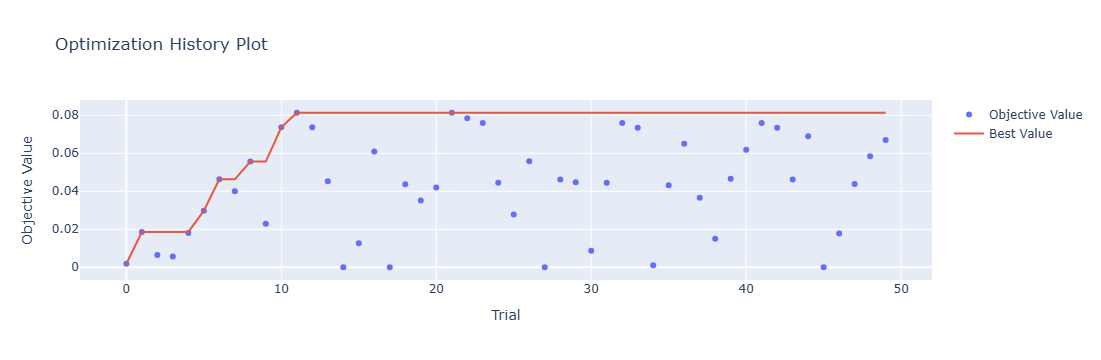

In [74]:
print(study_canny.best_params)
optuna.visualization.plot_optimization_history(study_canny)

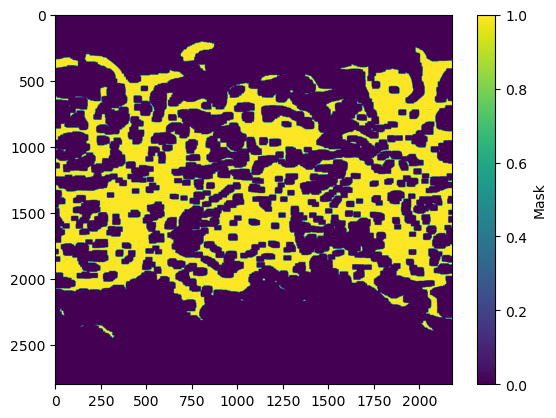

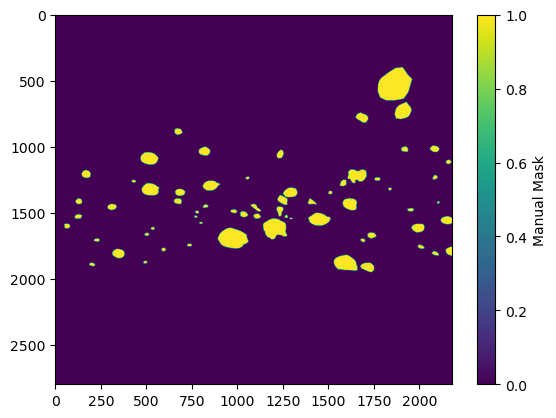

0.081


In [75]:
# Application of Canny detector with best parameters (study.best_params)

canny = cv2.Canny(data_clahe, threshold1 = study_canny.best_params['tr1'], threshold2 = study_canny.best_params['tr2'])
canny = cv2.normalize(canny, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
_, canny_bin = cv2.threshold(canny, 0, 1, cv2.THRESH_BINARY)

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (study_canny.best_params['kernel_size_close'], study_canny.best_params['kernel_size_close']))
closed = cv2.morphologyEx(canny_bin, cv2.MORPH_CLOSE, kernel)
kernel2 = np.ones((study_canny.best_params['kernel_size_dil'], study_canny.best_params['kernel_size_dil']), dtype=np.uint8)
dilated_canny = cv2.erode(closed, kernel2, iterations=1)

plt.imshow(dilated_canny, aspect='auto', cmap='viridis')
plt.colorbar(label='Mask') 
plt.show()

plt.imshow(data_man, aspect='auto', cmap='viridis')
plt.colorbar(label='Manual Mask') 
plt.show()

error = jaccard_score(
    data_man.flatten(), 
    dilated_canny.flatten(), 
    average='binary'  # For binary segmentation
    )
print(round(error, 3))

write_ascii_grid(Nx, Ny, xMin, xMax, yMin, yMax, zMin, zMax, dilated_canny, '1_OpenCV_Canny.grd')

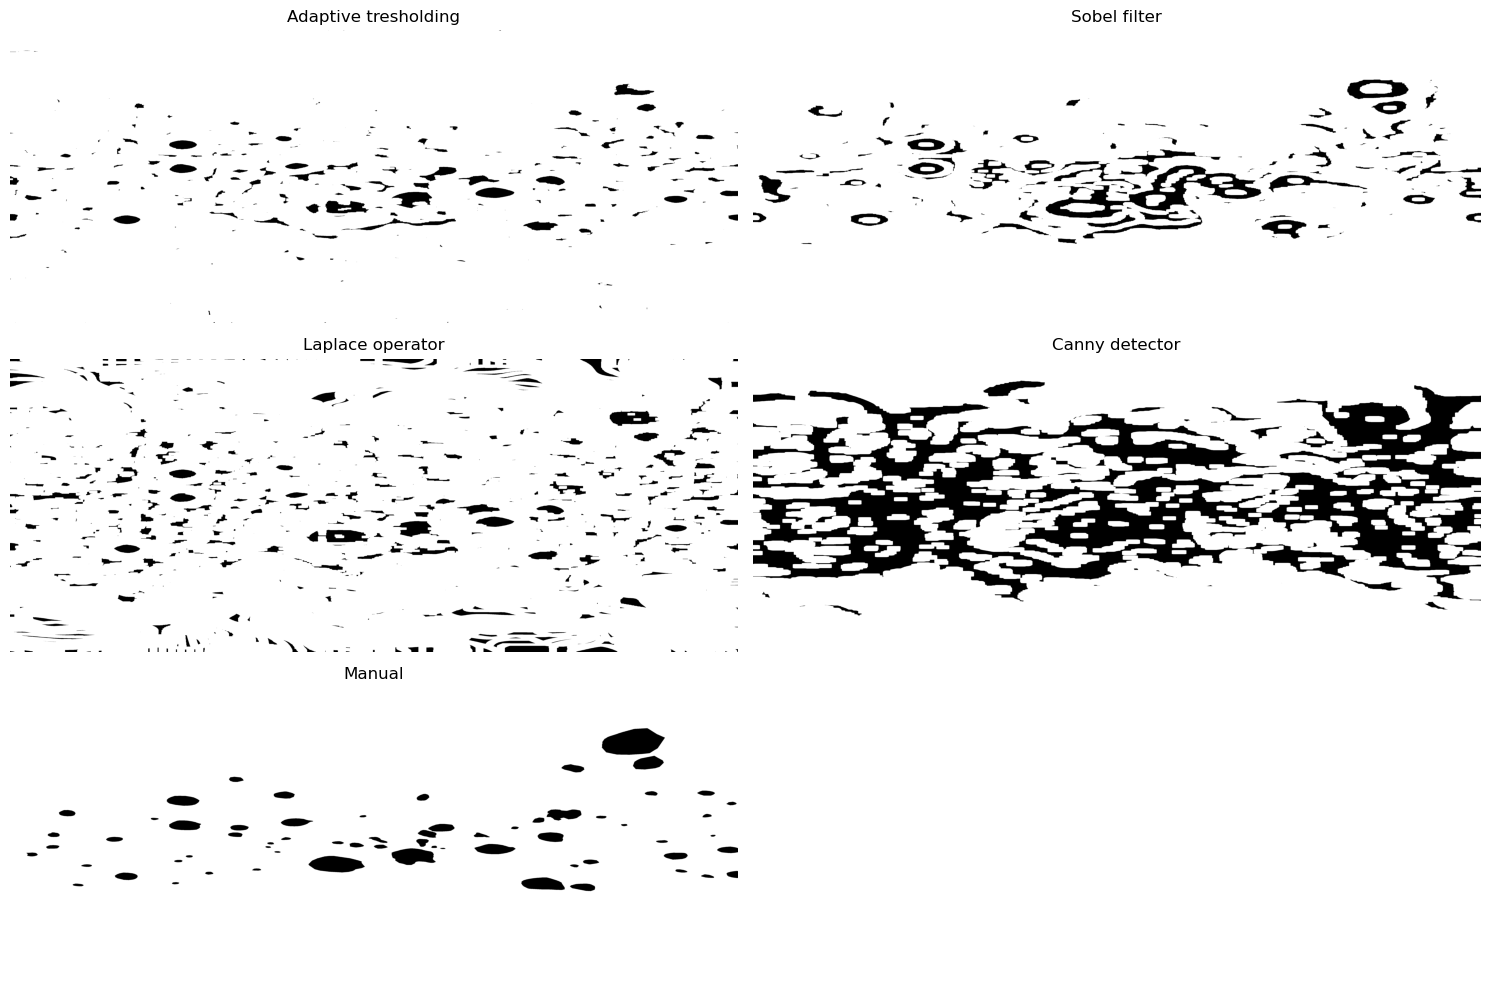

In [76]:
# Visualization of results
plt.figure(figsize=(15, 10))

plt.subplot(3, 2, 1)
plt.imshow(1-dilated_AdTr, cmap='gray', aspect='auto')
plt.title('Adaptive tresholding')
plt.axis('off')

plt.subplot(3, 2, 2)
plt.imshow(1-dilated_sob, cmap='gray', aspect='auto')
plt.title('Sobel filter')
plt.axis('off')

plt.subplot(3, 2, 3)
plt.imshow(1-dilated_lap, cmap='gray', aspect='auto')
plt.title('Laplace operator')
plt.axis('off')

plt.subplot(3, 2, 4)
plt.imshow(1-dilated_canny, cmap='gray', aspect='auto')
plt.title('Canny detector')
plt.axis('off')

plt.subplot(3, 2, 5)
plt.imshow(1-data_man, cmap='gray', aspect='auto')
plt.title('Manual')
plt.axis('off')

plt.tight_layout()
plt.show()